# Time Series Anomaly Detection Using GRU (Gated Recurrent Units)

Anomaly detection in time series data is a critical task in various domains. Gated Recurrent Units (GRUs), a type of Recurrent Neural Network (RNN), have shown promise in handling sequential data due to their ability to capture long-term dependencies and efficiently learn temporal patterns.

In this project, we leverage GRU-based autoencoders to perform anomaly detection on time series data. By training the GRU model to reconstruct normal sequences, the model learns to minimize reconstruction error for typical patterns. Anomalies are then identified based on significant deviations in the reconstruction error, allowing us to effectively detect unusual events within the time series.


## Importing necessary libraries

1. **System and File Handling:** sys, os, and csv for managing system-specific parameters, file paths, and CSV file operations.

2. **Machine Learning and Metrics:** sklearn.metrics provides metrics like F1 Score, ROC AUC, Precision-Recall curves, and AUC for evaluating model performance. sklearn.preprocessing.StandardScaler is used for data normalization.

3. **Data Manipulation and Plotting:** numpy and pandas for efficient data handling and manipulation, and matplotlib.pyplot for visualizing time series data and model results.

4. **Deep Learning with PyTorch:** torch, torch.nn, and torch.optim for building, training, and optimizing neural network models, specifically focusing on implementing and training a GRU (Gated Recurrent Unit) for anomaly detection.

In [8]:
import sys
import csv
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
#increasing the field size limit for CSV files
csv.field_size_limit(sys.maxsize)

#loading anomaly types mapping ( from the mentioned paper GitHub)
anomaly_types_df = pd.read_csv('/Users/tinahajinejad/Downloads/anomaly_types.csv', delimiter=';')
filename_to_anomaly_type = {row['name']: row['anomaly_type_2'] for _, row in anomaly_types_df.iterrows()}


#path of the older containing the datasets
folder_path = '/Users/tinahajinejad/Desktop/ALS new project/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData'


In [10]:
#function to load time series data
def load_time_series(file_path):
    
    data = pd.read_csv(file_path, header=None, sep='\t' if any(str(num) in file_path for num in [204, 205, 206, 207, 208, 225, 226, 242, 243]) else ',', engine='python')
    data = data.apply(pd.to_numeric, errors='coerce')
    
    return data.values.flatten()

#function to pad data (sequencing by windows)
def pad_data(data, window_size=100):
    
    padding_length = (window_size - len(data) % window_size) % window_size
    return np.pad(data, (0, padding_length), 'constant')



#reshaping the padded data to ensure compatible sizes 
def reshape_data(data, window_size=100):
    
    if len(data) < window_size:
        return torch.tensor([])  #this line returns an empty tensor if data is too short
    padded_data = pad_data(data, window_size)
    
    return torch.tensor(padded_data.reshape(-1, window_size, 1), dtype=torch.float32)

#this is a scaling function to normalize data ( 100 is the chosen window size)
def scale_data(train_data, test_data):
    
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1, 100, 1)
    test_data = scaler.transform(test_data.reshape(-1, 1)).reshape(-1, 100, 1)
    
    return train_data, test_data

## Deep Learning Model (GRU AE)


**Encoder**: The encoder GRU layer compresses the input sequence into a hidden state, effectively capturing the essential patterns and features of the time series.

**Decoder:** The decoder GRU layer attempts to reconstruct the original input sequence from the hidden state generated by the encoder. This reconstruction is critical for identifying anomalies, as deviations from normal patterns lead to higher reconstruction errors.

**Fully Connected Layer (fc):** The final fully connected layer maps the output of the decoder back to the original input dimension, completing the reconstruction process.

The forward method defines the forward pass of the model, where the input sequence is encoded, and the resulting hidden state is decoded and transformed back into the original input format. The reconstruction error, calculated by comparing the input with the output, is used to detect anomalies in the time series data.

In [11]:
#GRU Autoencoder model definition


class GRUAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GRUAutoencoder, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        _, h = self.encoder(x)
        h_repeated = h.repeat(x.size(1), 1, 1).permute(1, 0, 2)  # Repeat hidden state across the sequence length
        decoded, _ = self.decoder(h_repeated)
        out = self.fc(decoded)
        return out


In [12]:
#the training function


def train_model(model, train_data, num_epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss() #I used a simple loss function here. Other loss functions could work better in this case
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #using the ADAM optimizer 

    for epoch in range(num_epochs):
        output = model(train_data)
        output = output[:, :train_data.size(1), :]  #this ensures the output matches the size of train_data
        loss = criterion(output, train_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')  #to track the process of training

In [13]:
#function to evaluate the model's performance. If the predicted center falls any where in the close proximity of the actual anomaly interval, the prediction is considered correct.

def evaluate_prediction(predicted_center, anomaly_start, anomaly_end):
    L = anomaly_end - anomaly_start + 1
    min_val = min(anomaly_start - L, anomaly_start - 100)
    max_val = max(anomaly_end + L, anomaly_end + 100)
    return min_val < predicted_center < max_val



Processing file: 183_UCR_Anomaly_qtdbSel100MLII_4000_13400_13800.txt
Processing file: 194_UCR_Anomaly_sddb49_20000_67950_68200.txt
Processing file: 069_UCR_Anomaly_DISTORTEDinsectEPG5_3200_8500_8501.txt
Processing file: 023_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z5_5000_8612_8716.txt
Processing file: 212_UCR_Anomaly_Italianpowerdemand_8913_29480_29504.txt
Processing file: 180_UCR_Anomaly_ltstdbs30791ES_20000_52600_52800.txt
Processing file: 058_UCR_Anomaly_DISTORTEDapneaecg_10000_12240_12308.txt
Processing file: 130_UCR_Anomaly_GP711MarkerLFM5z4_4000_6527_6645.txt
Correct prediction for 130_UCR_Anomaly_GP711MarkerLFM5z4_4000_6527_6645.txt.


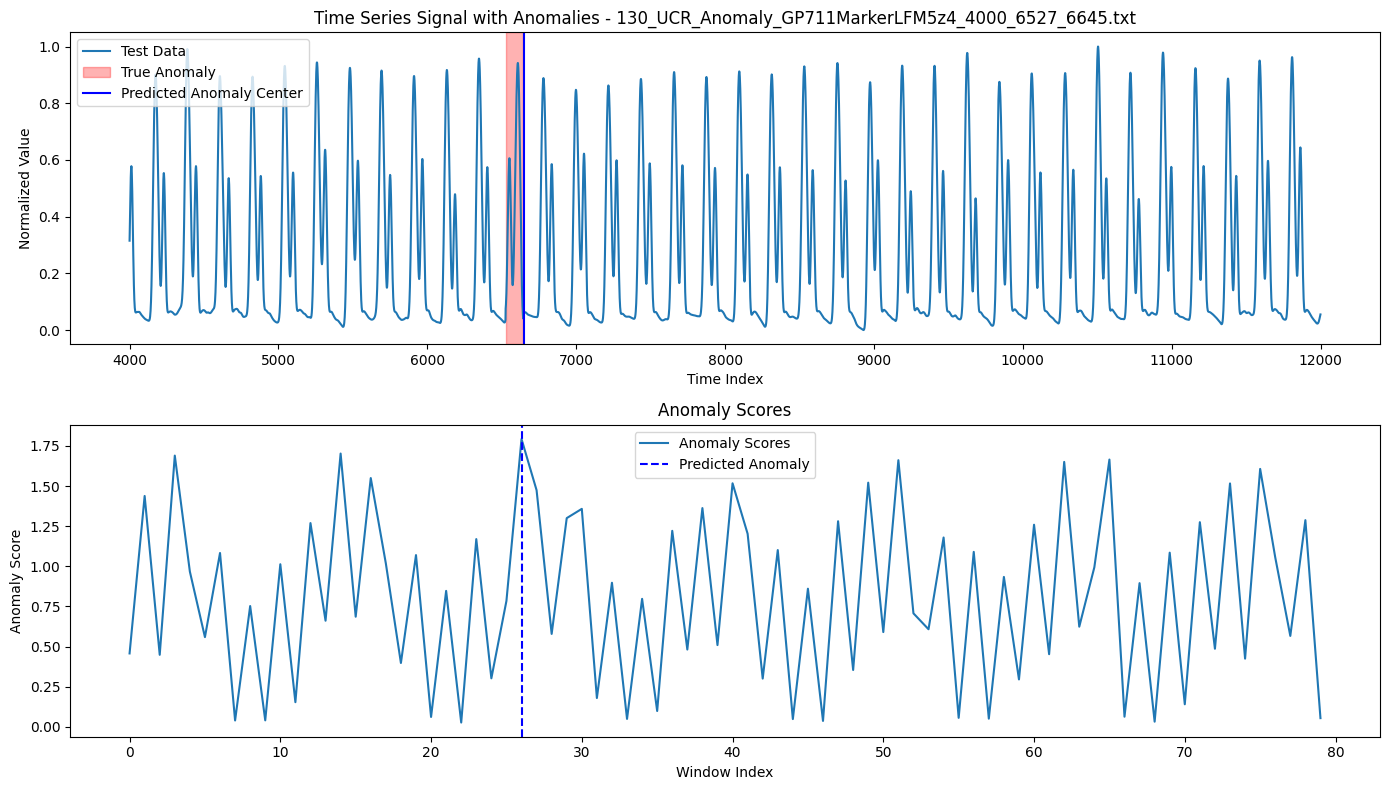

Processing file: 079_UCR_Anomaly_DISTORTEDresperation2_30000_168250_168250.txt
Processing file: 224_UCR_Anomaly_mit14046longtermecg_76123_191200_191700.txt
Processing file: 044_UCR_Anomaly_DISTORTEDPowerDemand1_9000_18485_18821.txt
Processing file: 233_UCR_Anomaly_mit14157longtermecg_18913_24500_24501.txt
Processing file: 042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt
Processing file: 114_UCR_Anomaly_CIMIS44AirTemperature2_4000_5703_5727.txt
Processing file: 204_UCR_Anomaly_CHARISfive_12412_15000_15070.txt
Skipping 204_UCR_Anomaly_CHARISfive_12412_15000_15070.txt due to insufficient data for reshaping.
Processing file: 241_UCR_Anomaly_taichidbS0715Master_250000_837400_839100.txt
Processing file: 028_UCR_Anomaly_DISTORTEDInternalBleeding17_1600_3198_3309.txt
Processing file: 026_UCR_Anomaly_DISTORTEDInternalBleeding15_1700_5684_5854.txt
Processing file: 092_UCR_Anomaly_DISTORTEDtiltAPB4_20000_67995_67996.txt
Processing file: 214_UCR_Anomaly_STAFFIIIDatabase_34211_12572

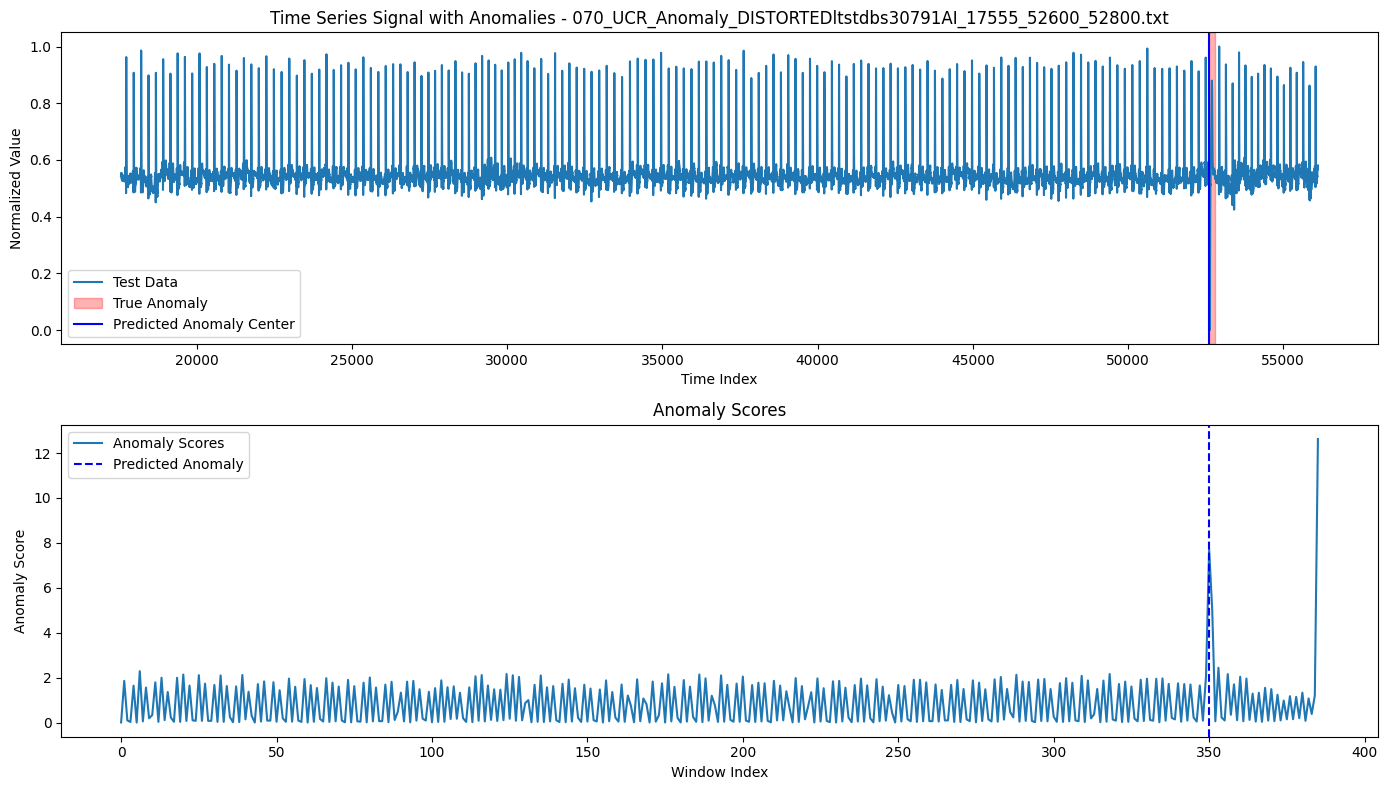

Processing file: 006_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature2_4000_5703_5727.txt
Processing file: 036_UCR_Anomaly_DISTORTEDInternalBleeding9_4200_6599_6681.txt
Processing file: 198_UCR_Anomaly_tiltAPB2_50000_124159_124985.txt
Processing file: 149_UCR_Anomaly_Lab2Cmac011215EPG5_7000_17390_17520.txt
Correct prediction for 149_UCR_Anomaly_Lab2Cmac011215EPG5_7000_17390_17520.txt.


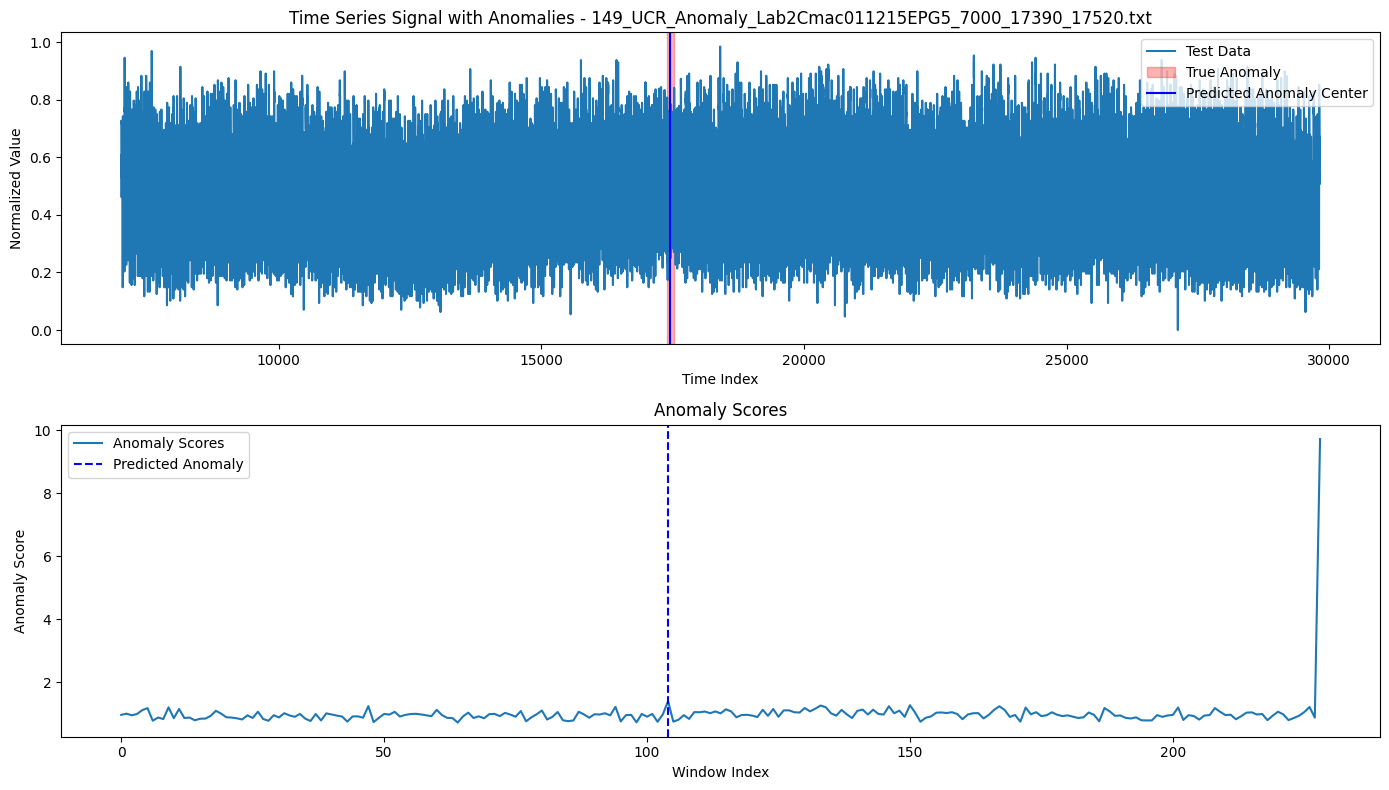

Processing file: 032_UCR_Anomaly_DISTORTEDInternalBleeding4_1000_4675_5033.txt
Processing file: 099_UCR_Anomaly_NOISEInternalBleeding6_1500_3474_3629.txt
Correct prediction for 099_UCR_Anomaly_NOISEInternalBleeding6_1500_3474_3629.txt.


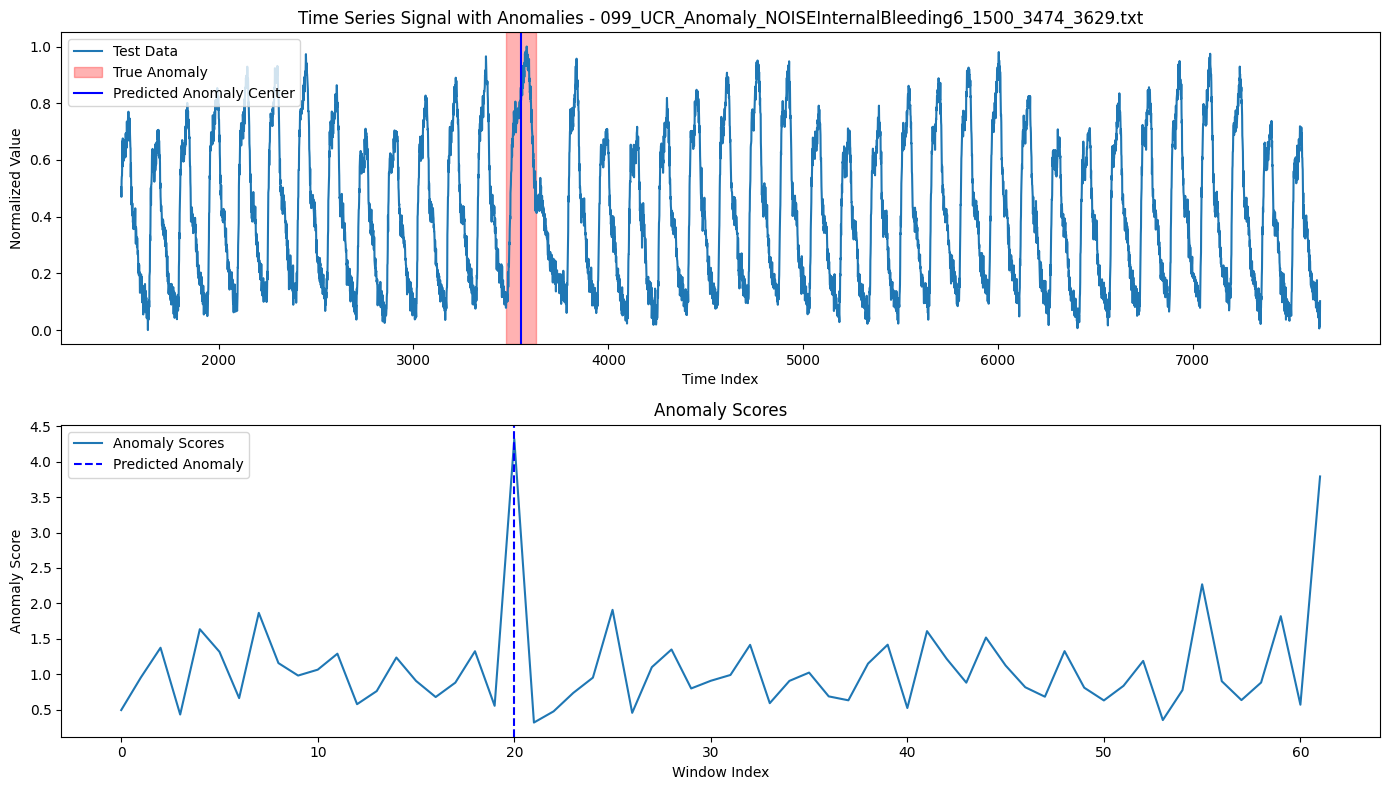

Processing file: 137_UCR_Anomaly_InternalBleeding18_2300_4485_4587.txt
Processing file: 216_UCR_Anomaly_STAFFIIIDatabase_37216_160720_161370.txt
Correct prediction for 216_UCR_Anomaly_STAFFIIIDatabase_37216_160720_161370.txt.


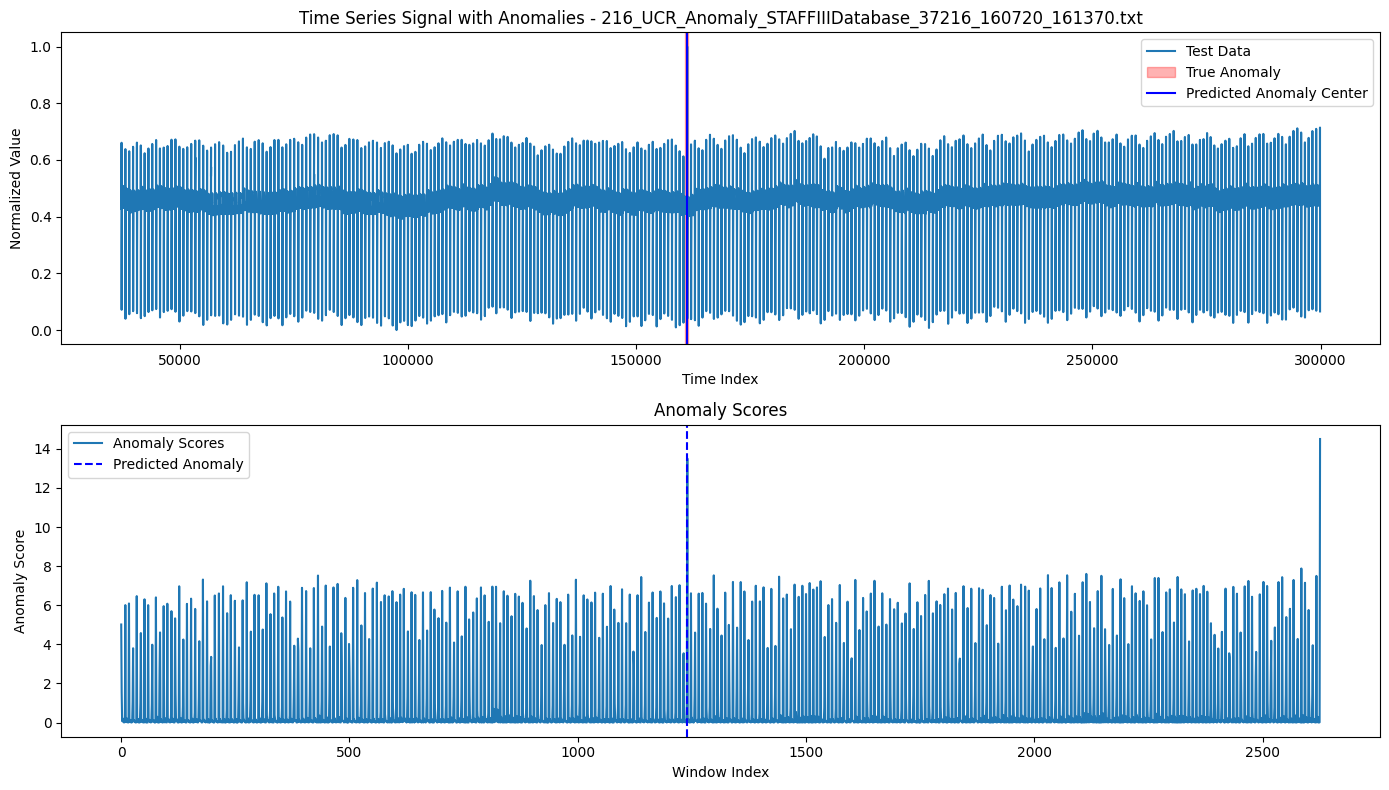

Processing file: 057_UCR_Anomaly_DISTORTEDapneaecg4_6000_16000_16100.txt
Processing file: 087_UCR_Anomaly_DISTORTEDsel840mECG1_17000_51370_51740.txt
Processing file: 103_UCR_Anomaly_NOISETkeepThirdMARS_3500_4711_4809.txt
Correct prediction for 103_UCR_Anomaly_NOISETkeepThirdMARS_3500_4711_4809.txt.


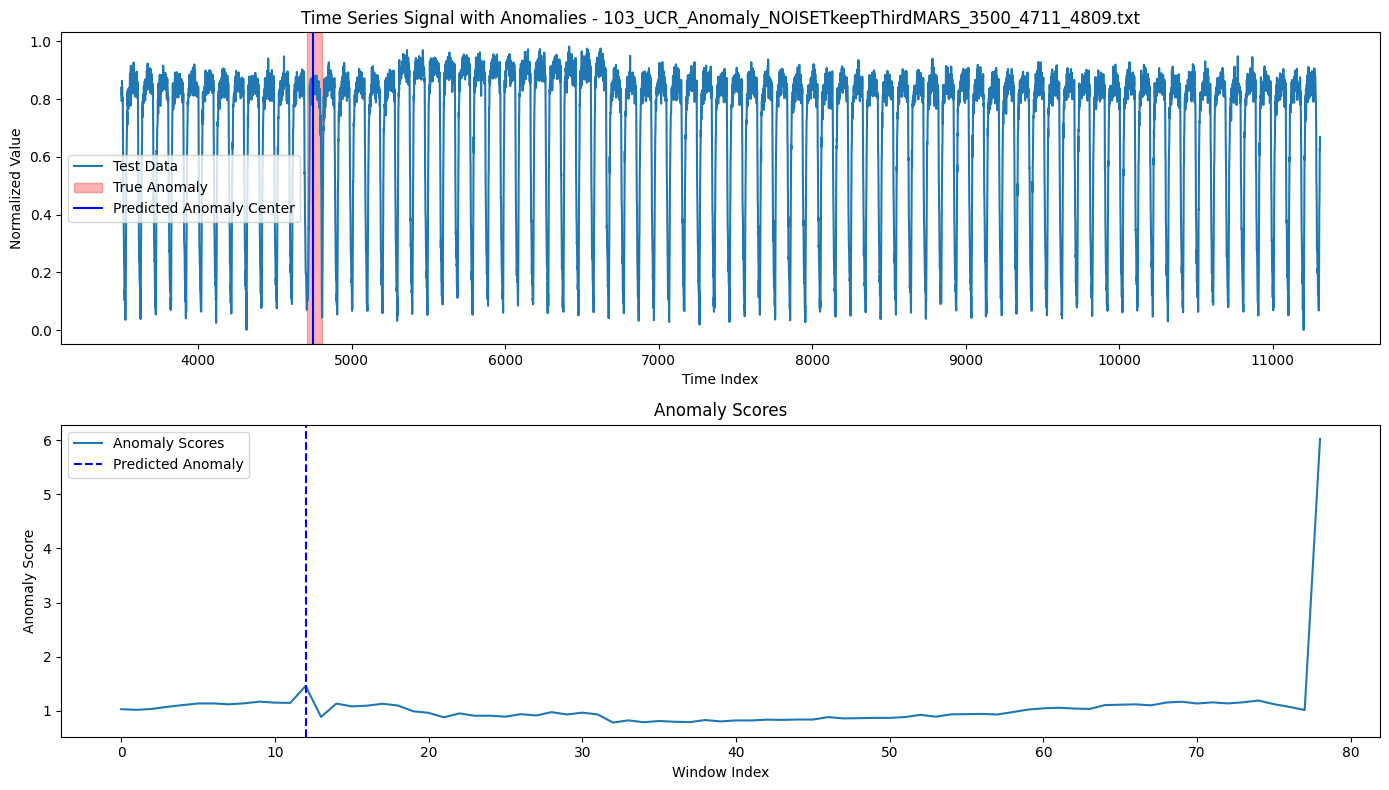

Processing file: 223_UCR_Anomaly_mit14046longtermecg_74123_131200_131700.txt
Processing file: 179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800.txt
Correct prediction for 179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800.txt.


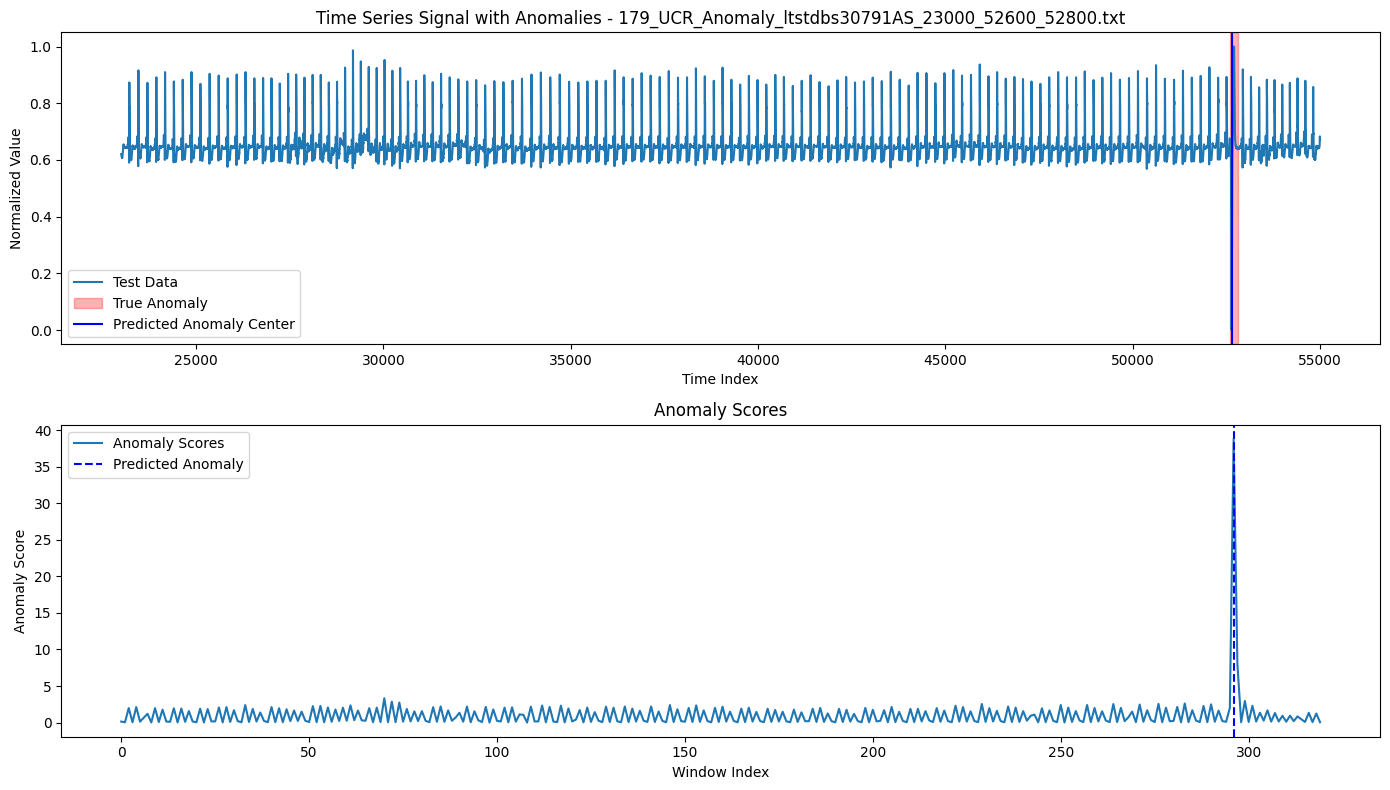

Processing file: 178_UCR_Anomaly_ltstdbs30791AI_17555_52600_52800.txt
Correct prediction for 178_UCR_Anomaly_ltstdbs30791AI_17555_52600_52800.txt.


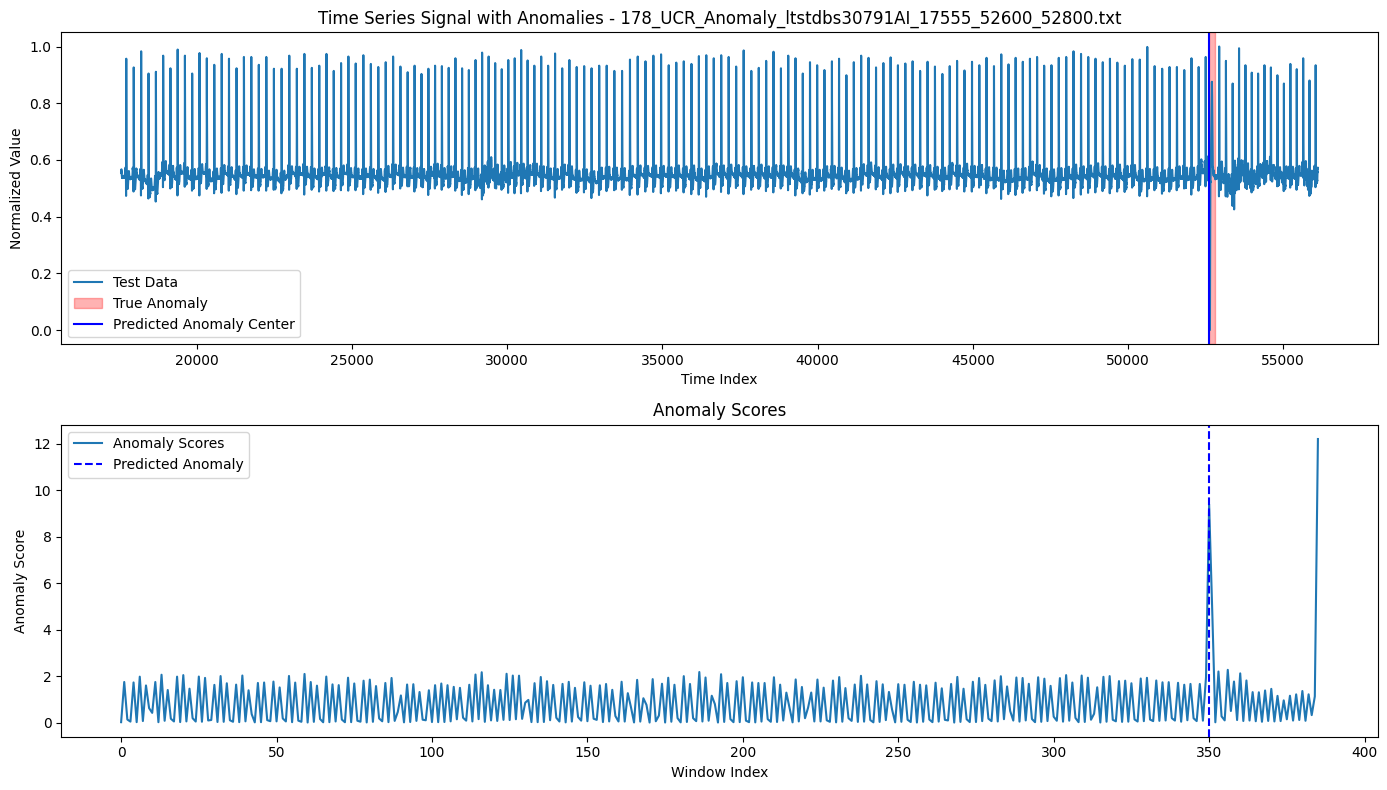

Processing file: 189_UCR_Anomaly_resperation3_45000_158250_158251.txt
Processing file: 225_UCR_Anomaly_mit14046longtermecg_81214_143000_143300.txt
Skipping 225_UCR_Anomaly_mit14046longtermecg_81214_143000_143300.txt due to insufficient data for reshaping.
Processing file: 190_UCR_Anomaly_resperation4_70000_128430_128431.txt
Processing file: 229_UCR_Anomaly_mit14134longtermecg_16363_57960_57970.txt
Processing file: 186_UCR_Anomaly_resperation1_100000_110260_110412.txt
Processing file: 064_UCR_Anomaly_DISTORTEDgaitHunt3_23400_38400_39200.txt
Processing file: 219_UCR_Anomaly_STAFFIIIDatabase_41612_64632_64852.txt
Processing file: 172_UCR_Anomaly_gaitHunt3_23400_38400_39200.txt
Processing file: 144_UCR_Anomaly_InternalBleeding9_4200_6599_6681.txt
Processing file: 027_UCR_Anomaly_DISTORTEDInternalBleeding16_1200_4187_4199.txt
Processing file: 033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370.txt
Correct prediction for 033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370.txt.


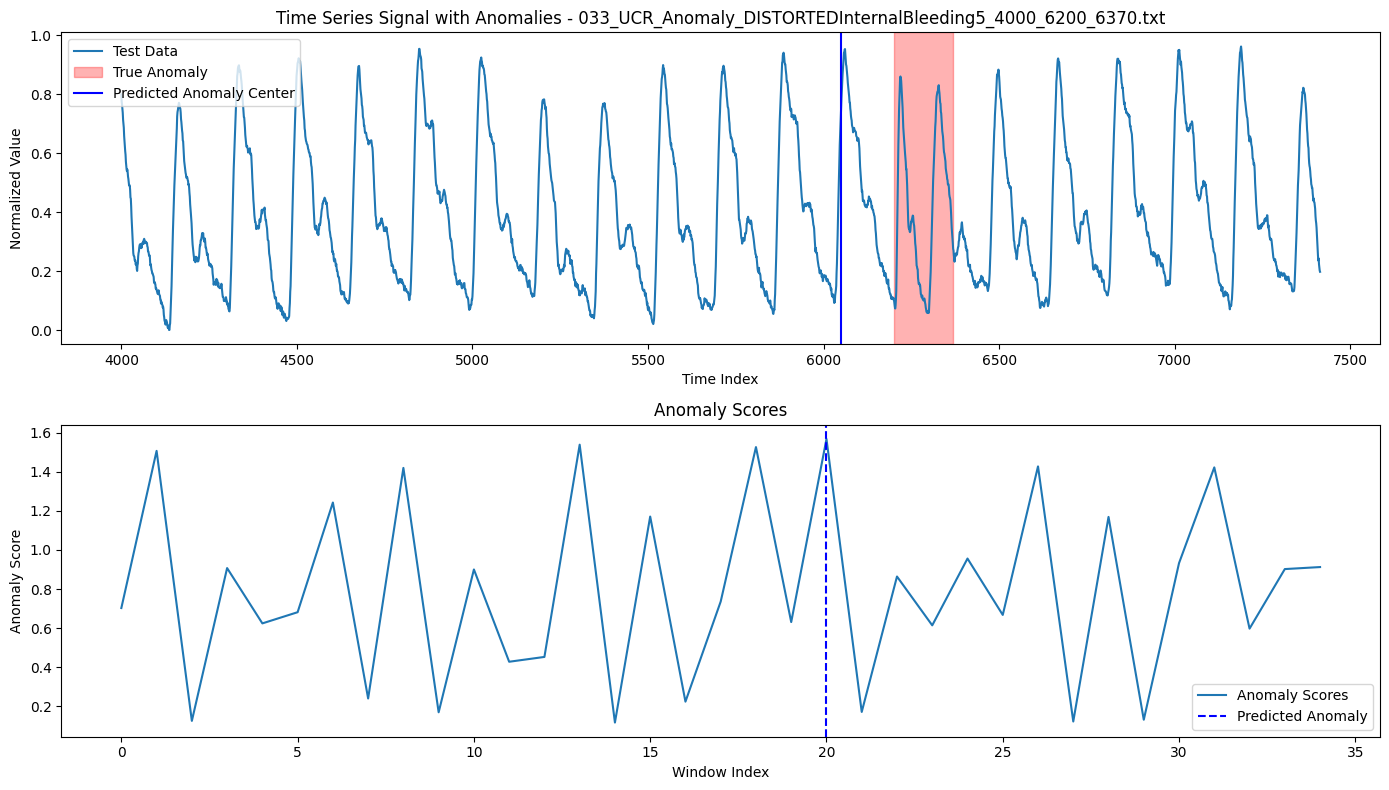

Processing file: 005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature1_4000_5391_5392.txt
Processing file: 003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt
Processing file: 250_UCR_Anomaly_weallwalk_2951_7290_7296.txt
Processing file: 039_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG3_5000_16390_16420.txt
Correct prediction for 039_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG3_5000_16390_16420.txt.


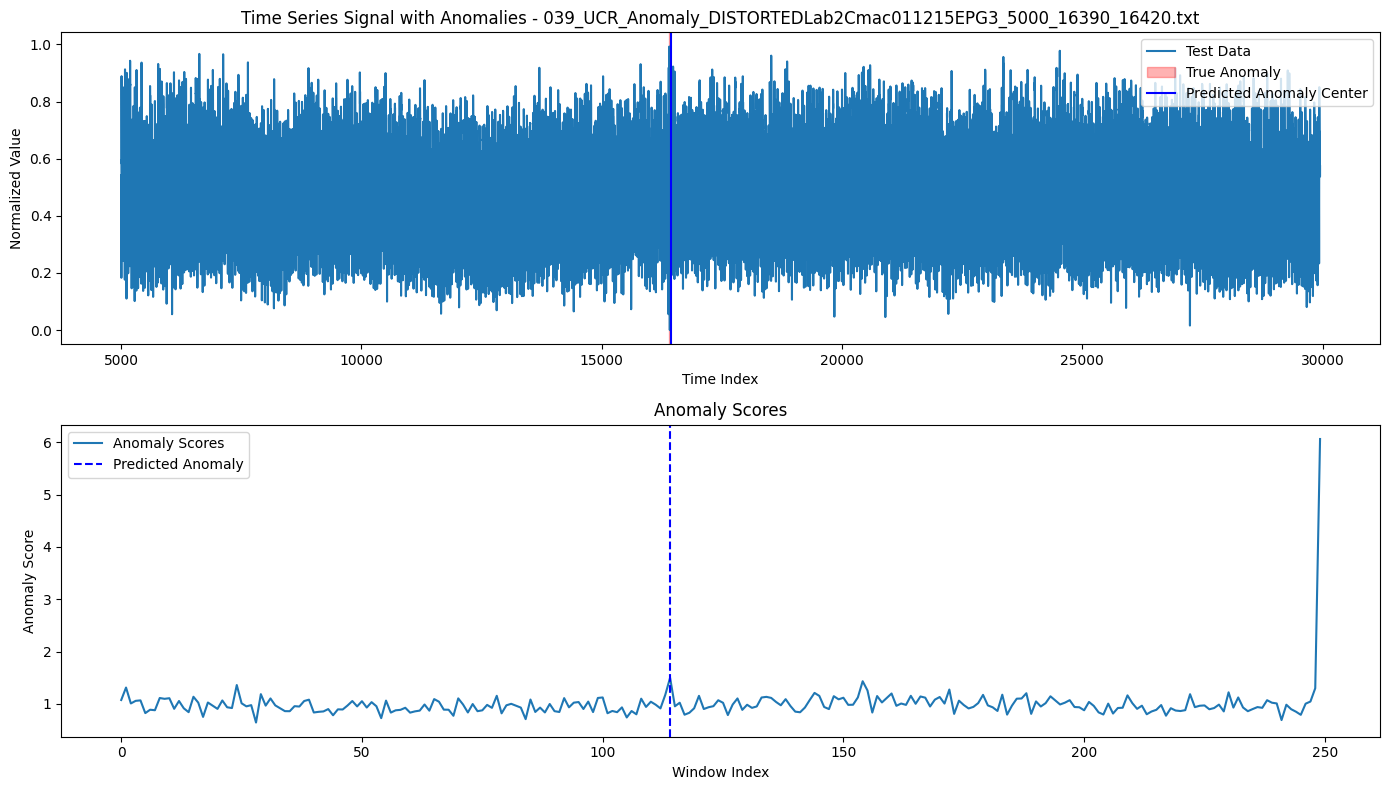

Processing file: 111_UCR_Anomaly_3sddb40_35000_46600_46900.txt
Processing file: 150_UCR_Anomaly_Lab2Cmac011215EPG6_7000_12190_12420.txt
Processing file: 002_UCR_Anomaly_DISTORTED2sddb40_35000_56600_56900.txt
Processing file: 221_UCR_Anomaly_STAFFIIIDatabase_45616_163632_164852.txt
Processing file: 077_UCR_Anomaly_DISTORTEDresperation11_58000_110800_110801.txt
Processing file: 227_UCR_Anomaly_mit14134longtermecg_11231_29000_29100.txt
Processing file: 222_UCR_Anomaly_mit14046longtermecg_56123_91200_91700.txt
Correct prediction for 222_UCR_Anomaly_mit14046longtermecg_56123_91200_91700.txt.


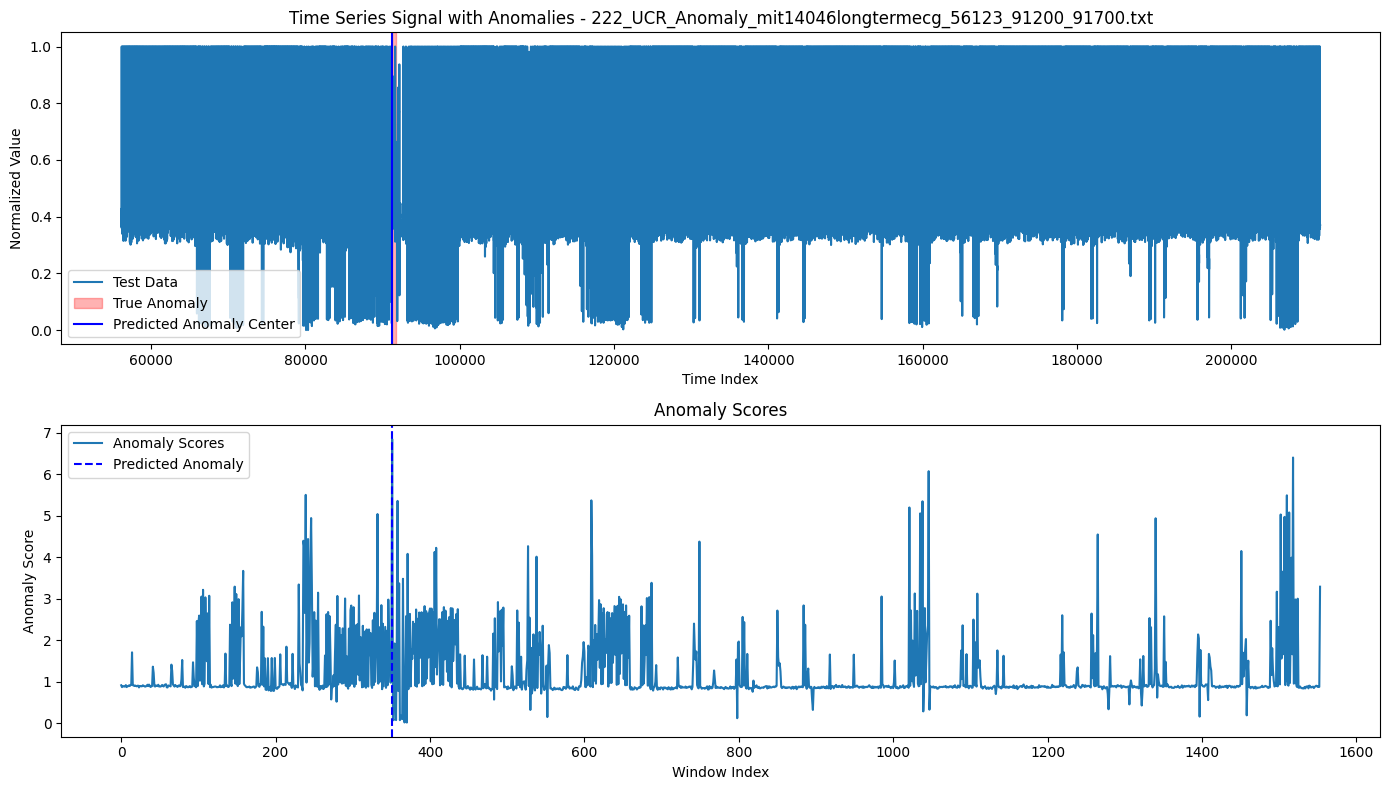

Processing file: 066_UCR_Anomaly_DISTORTEDinsectEPG2_3700_8000_8025.txt
Processing file: 013_UCR_Anomaly_DISTORTEDECG3_15000_16000_16100.txt
Processing file: 051_UCR_Anomaly_DISTORTEDTkeepSecondMARS_3500_9330_9340.txt
Processing file: 163_UCR_Anomaly_apneaecg2_10000_20950_21100.txt
Processing file: 141_UCR_Anomaly_InternalBleeding5_4000_6200_6370.txt
Correct prediction for 141_UCR_Anomaly_InternalBleeding5_4000_6200_6370.txt.


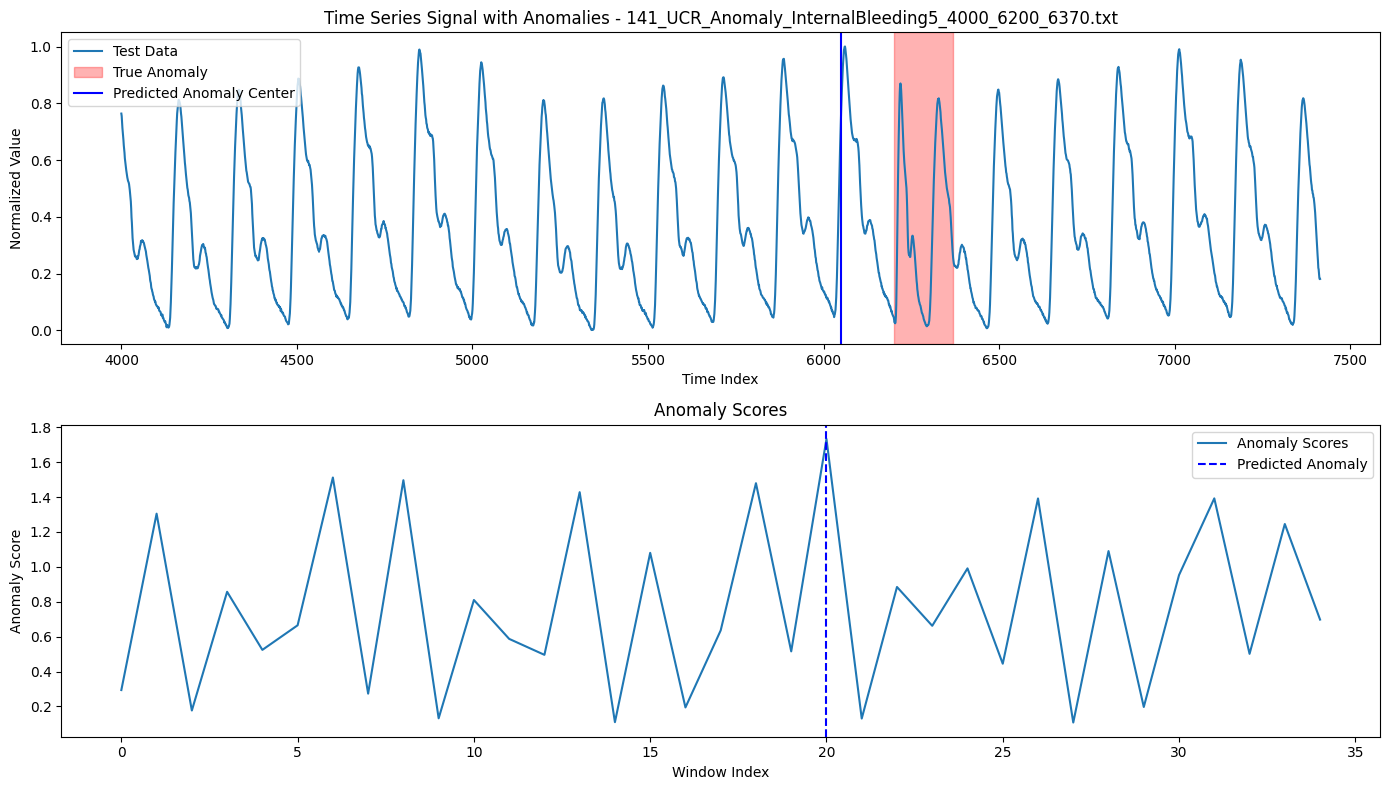

Processing file: 041_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG5_7000_17390_17520.txt
Processing file: 151_UCR_Anomaly_MesoplodonDensirostris_10000_19280_19440.txt
Correct prediction for 151_UCR_Anomaly_MesoplodonDensirostris_10000_19280_19440.txt.


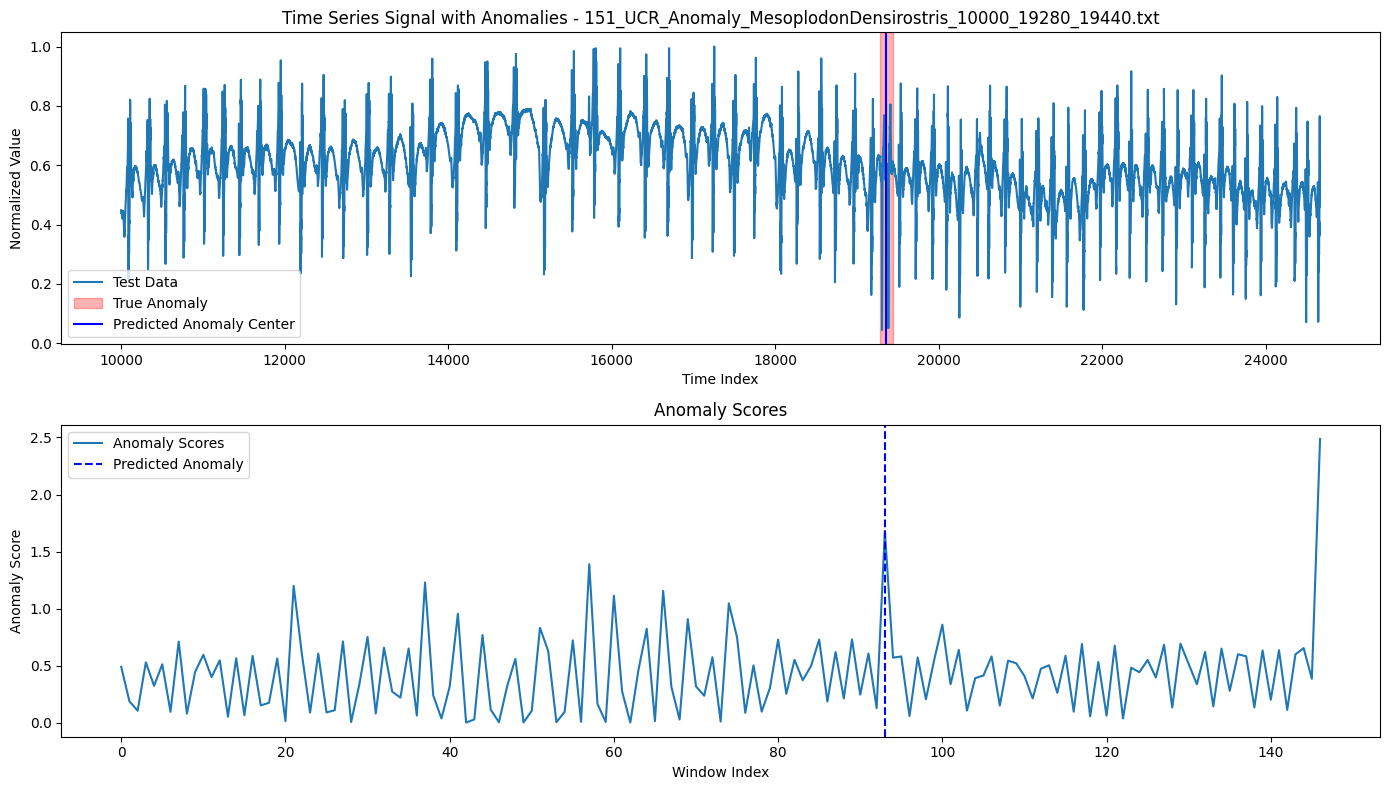

Processing file: 213_UCR_Anomaly_STAFFIIIDatabase_33211_126920_127370.txt
Correct prediction for 213_UCR_Anomaly_STAFFIIIDatabase_33211_126920_127370.txt.


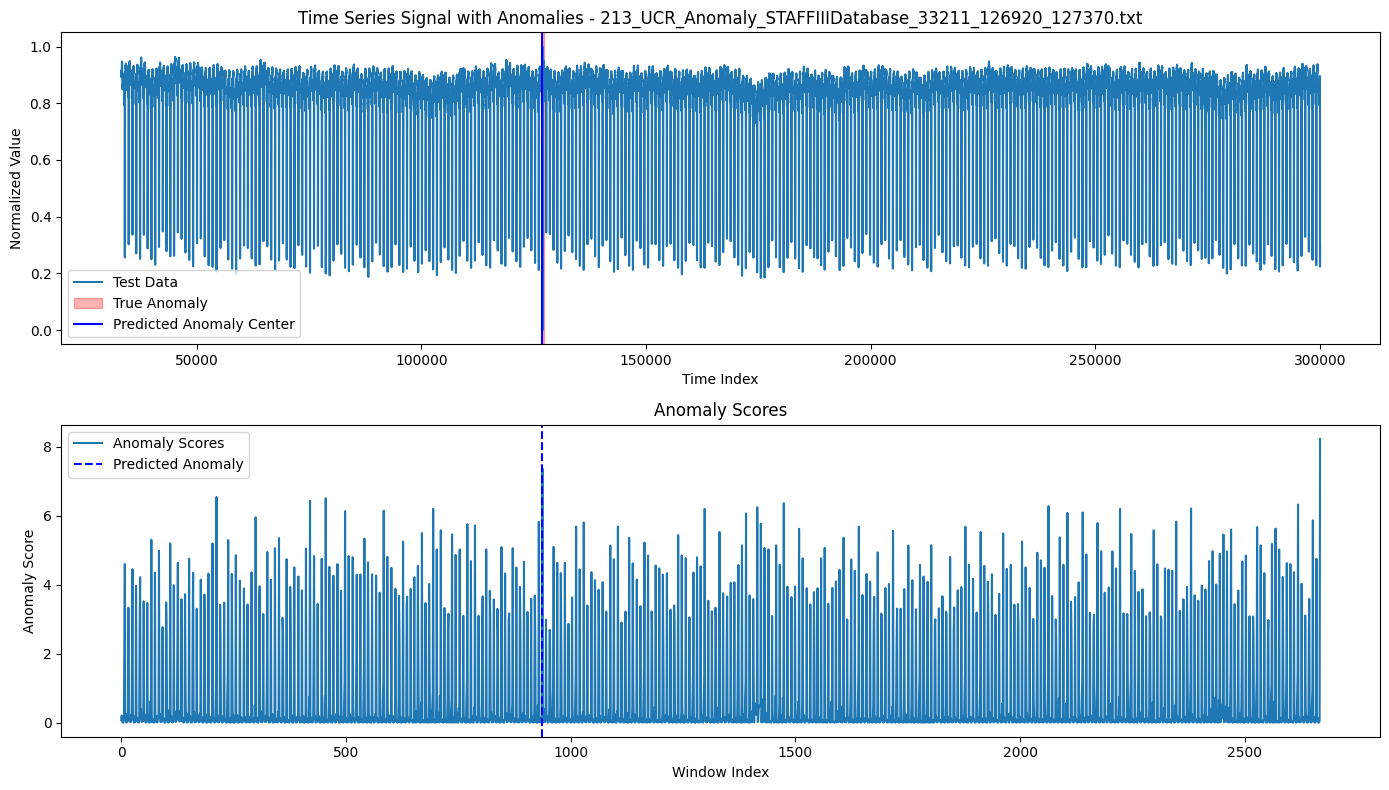

Processing file: 016_UCR_Anomaly_DISTORTEDECG4_5000_16900_17100.txt
Processing file: 074_UCR_Anomaly_DISTORTEDqtdbSel1005V_4000_12400_12800.txt
Processing file: 045_UCR_Anomaly_DISTORTEDPowerDemand2_14000_23357_23717.txt
Processing file: 247_UCR_Anomaly_tilt12755mtable_50211_121900_121980.txt
Processing file: 147_UCR_Anomaly_Lab2Cmac011215EPG3_5000_16390_16420.txt
Correct prediction for 147_UCR_Anomaly_Lab2Cmac011215EPG3_5000_16390_16420.txt.


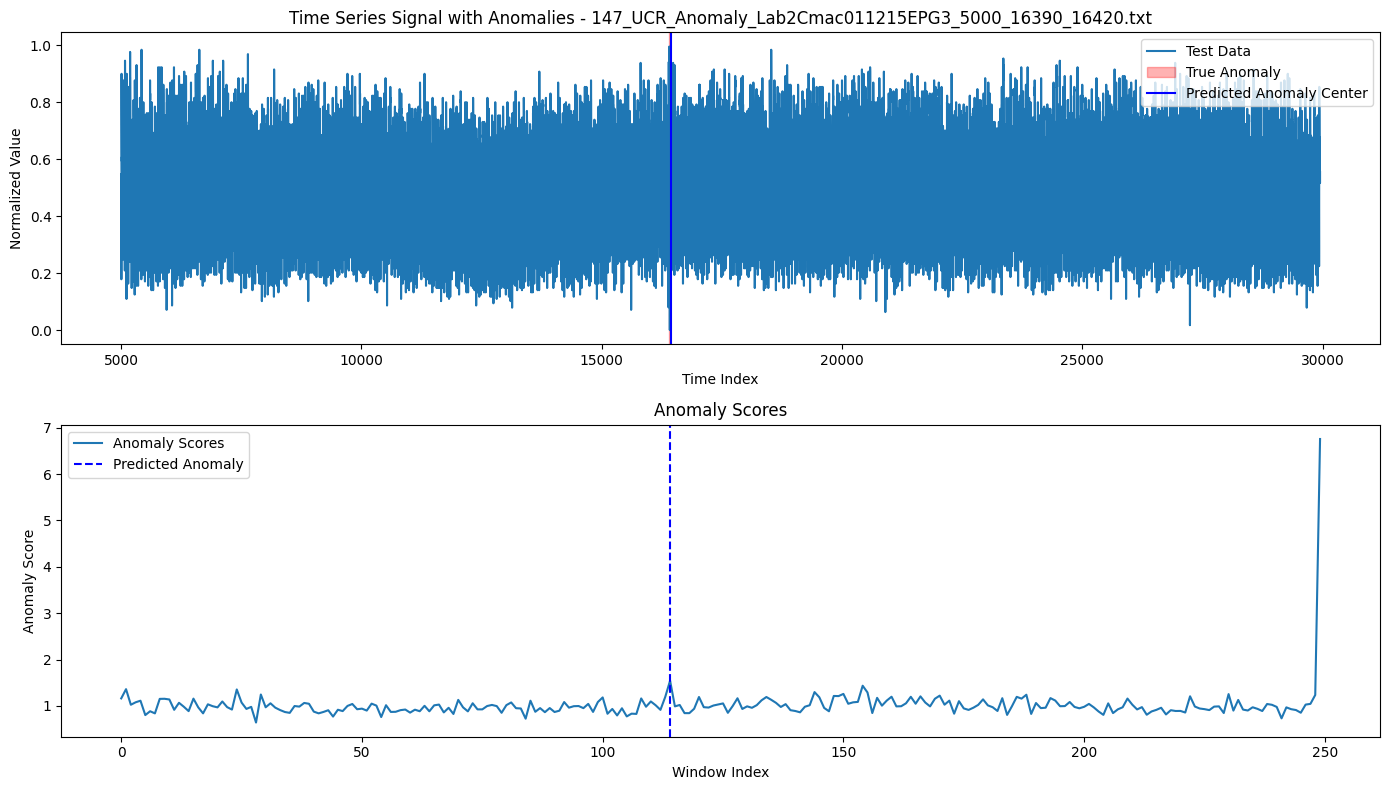

Processing file: 104_UCR_Anomaly_NOISEapneaecg4_6000_16000_16100.txt
Processing file: 062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt
Processing file: 108_UCR_Anomaly_NOISEresperation2_30000_168250_168250.txt
Processing file: 125_UCR_Anomaly_ECG4_5000_17000_17100.txt
Processing file: 030_UCR_Anomaly_DISTORTEDInternalBleeding19_3000_4187_4197.txt
Processing file: 106_UCR_Anomaly_NOISEgaitHunt2_18500_31200_31850.txt
Processing file: 146_UCR_Anomaly_Lab2Cmac011215EPG2_5000_27862_27932.txt
Processing file: 084_UCR_Anomaly_DISTORTEDs20101mML2_12000_35774_35874.txt
Correct prediction for 084_UCR_Anomaly_DISTORTEDs20101mML2_12000_35774_35874.txt.


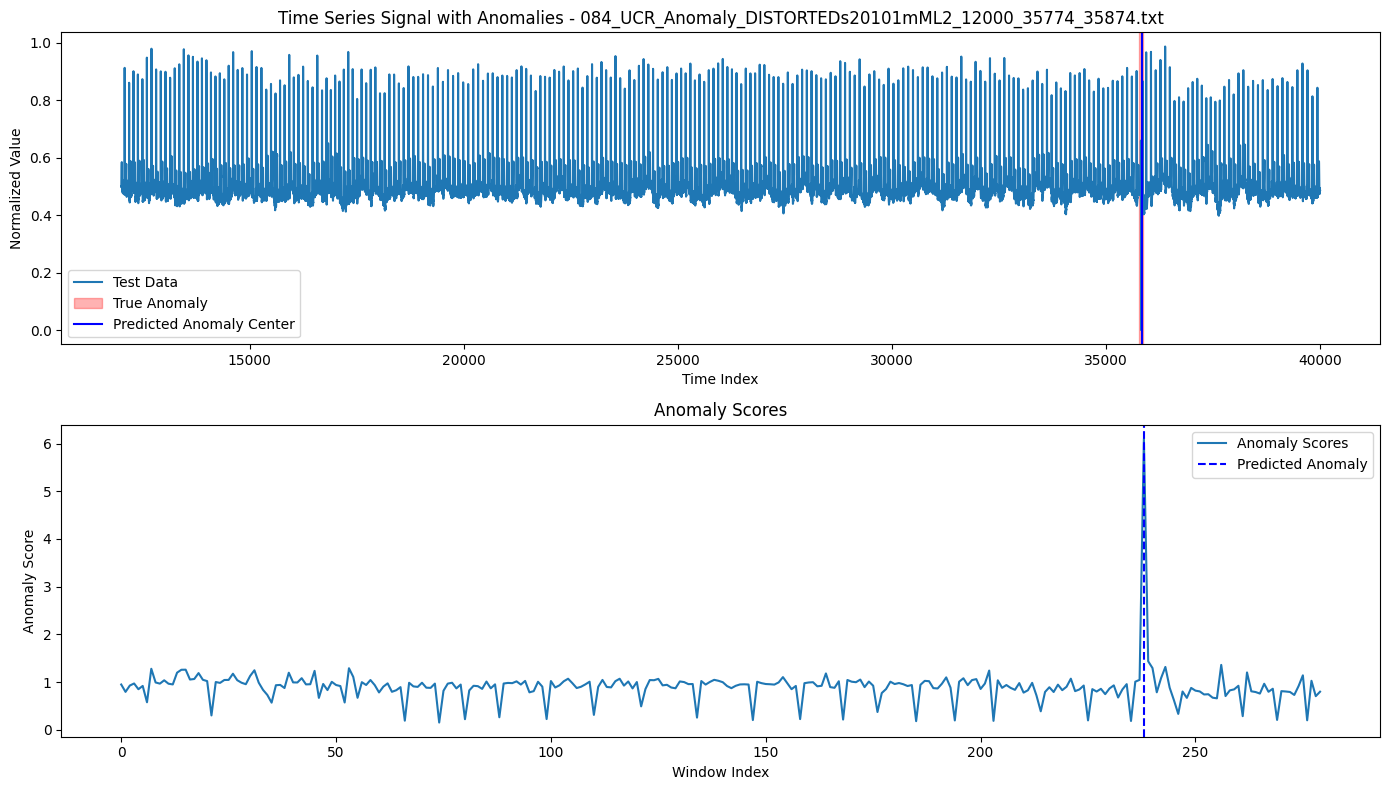

Processing file: 022_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z4_4000_6527_6645.txt
Processing file: 060_UCR_Anomaly_DISTORTEDgait2_22000_46500_46800.txt
Processing file: 202_UCR_Anomaly_CHARISfive_10411_10998_11028.txt
Processing file: 210_UCR_Anomaly_Italianpowerdemand_36123_74900_74996.txt
Processing file: 242_UCR_Anomaly_tilt12744mtable_100000_104630_104890.txt
Skipping 242_UCR_Anomaly_tilt12744mtable_100000_104630_104890.txt due to insufficient data for reshaping.
Processing file: 126_UCR_Anomaly_ECG4_8000_17000_17100.txt
Processing file: 055_UCR_Anomaly_DISTORTEDapneaecg2_10000_20950_21100.txt
Processing file: 165_UCR_Anomaly_apneaecg4_6000_16000_16100.txt
Processing file: 059_UCR_Anomaly_DISTORTEDgait1_20000_38500_38800.txt
Processing file: 220_UCR_Anomaly_STAFFIIIDatabase_43217_250720_251370.txt
Processing file: 199_UCR_Anomaly_tiltAPB3_40000_114000_114370.txt
Processing file: 048_UCR_Anomaly_DISTORTEDTkeepFifthMARS_3500_5988_6085.txt
Processing file: 193_UCR_Anomaly_s20101m_10000_3

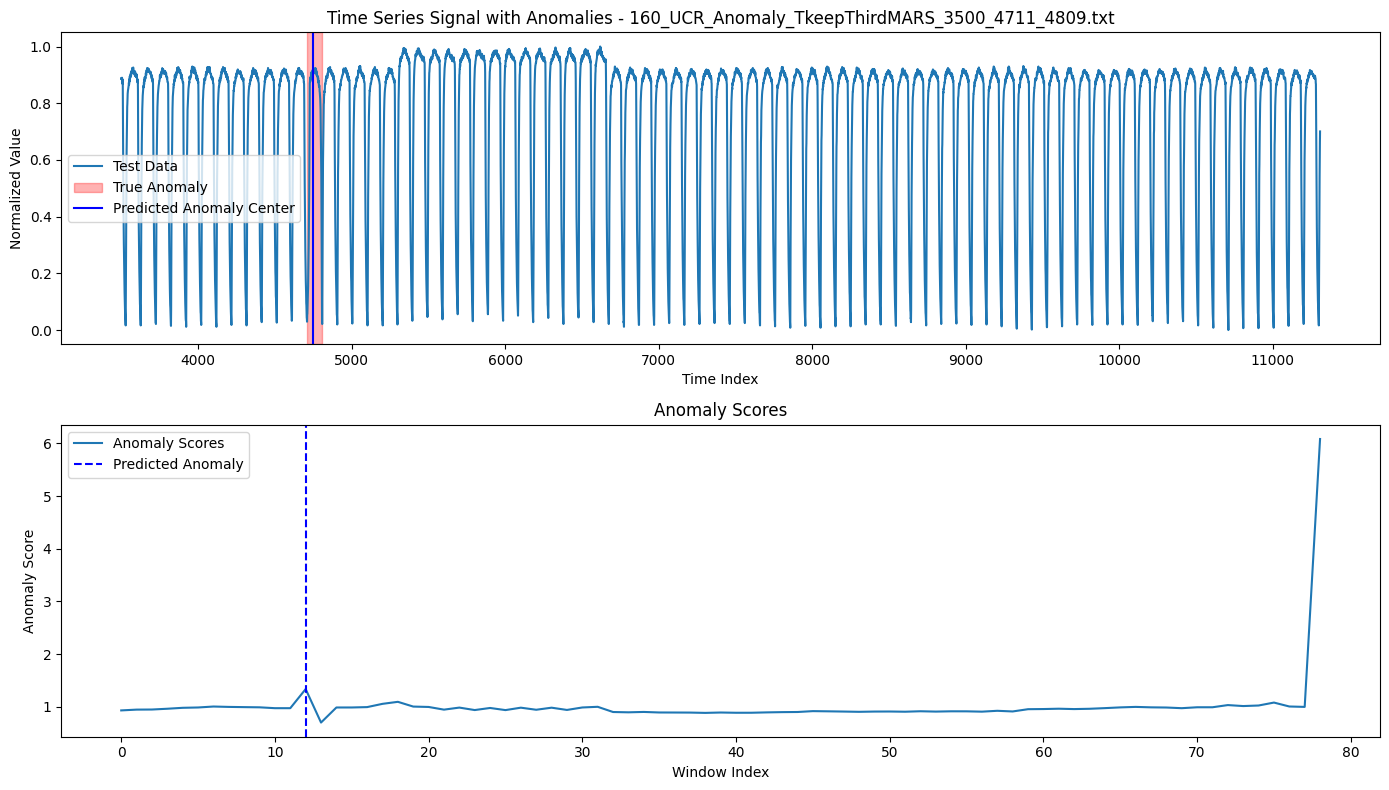

Processing file: 231_UCR_Anomaly_mit14134longtermecg_8763_47530_47790.txt
Processing file: 001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt
Correct prediction for 001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt.


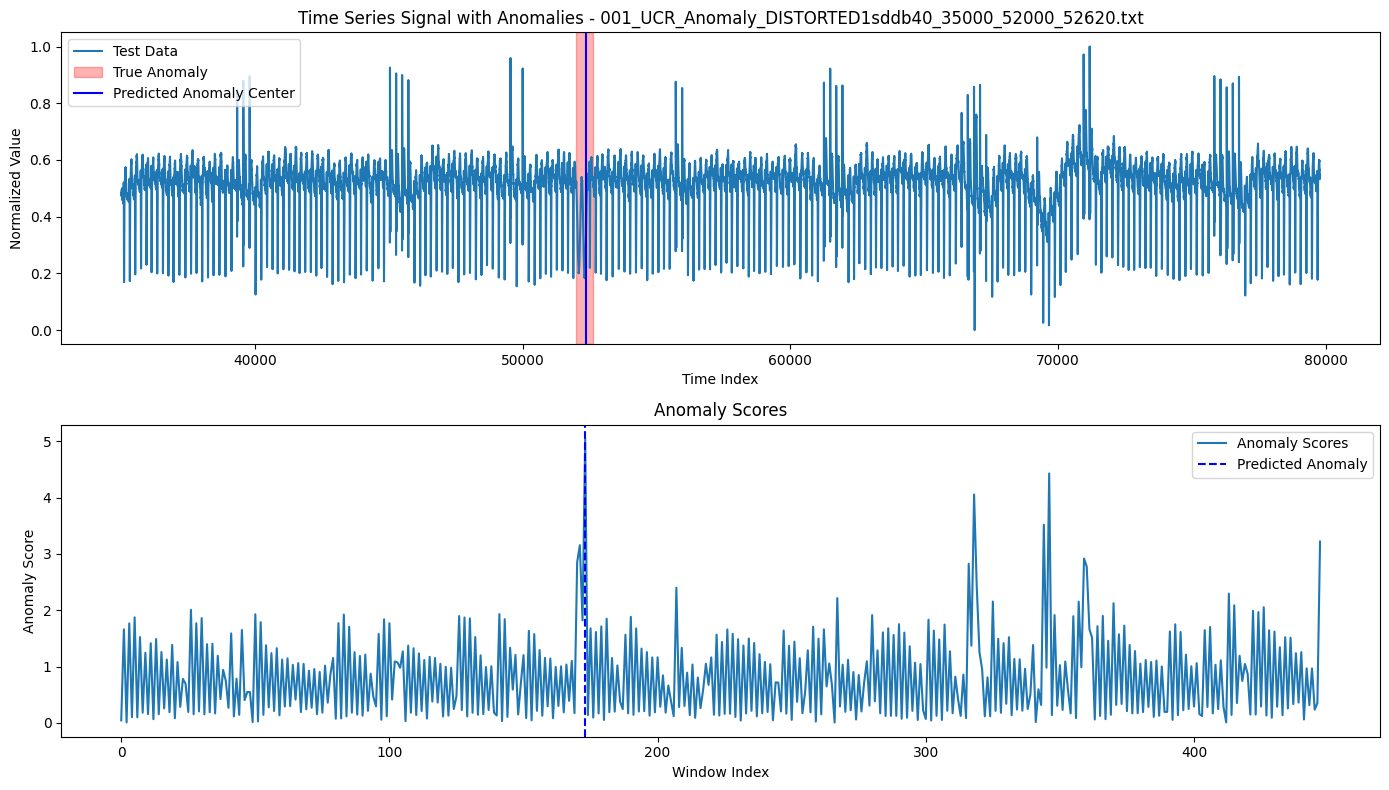

Processing file: 113_UCR_Anomaly_CIMIS44AirTemperature1_4000_5391_5392.txt
Processing file: 040_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG4_6000_17390_17520.txt
Processing file: 093_UCR_Anomaly_NOISE1sddb40_35000_52000_52620.txt
Correct prediction for 093_UCR_Anomaly_NOISE1sddb40_35000_52000_52620.txt.


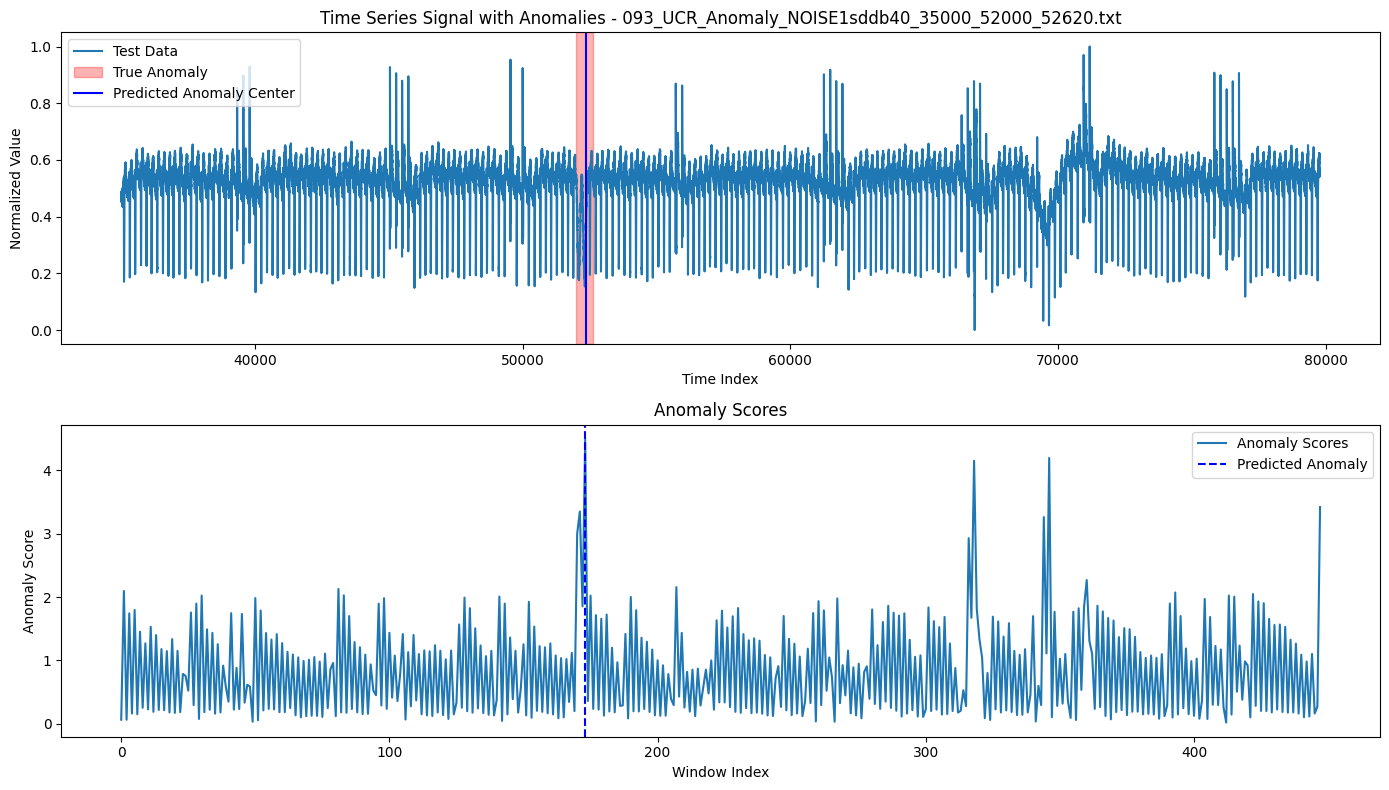

Processing file: 228_UCR_Anomaly_mit14134longtermecg_11361_47830_47850.txt
Processing file: 102_UCR_Anomaly_NOISEMesoplodonDensirostris_10000_19280_19440.txt
Processing file: 096_UCR_Anomaly_NOISEECG4_5000_16900_17100.txt
Processing file: 136_UCR_Anomaly_InternalBleeding17_1600_3198_3309.txt
Processing file: 082_UCR_Anomaly_DISTORTEDresperation4_70000_128430_128431.txt
Processing file: 097_UCR_Anomaly_NOISEGP711MarkerLFM5z3_5000_5948_5993.txt
Correct prediction for 097_UCR_Anomaly_NOISEGP711MarkerLFM5z3_5000_5948_5993.txt.


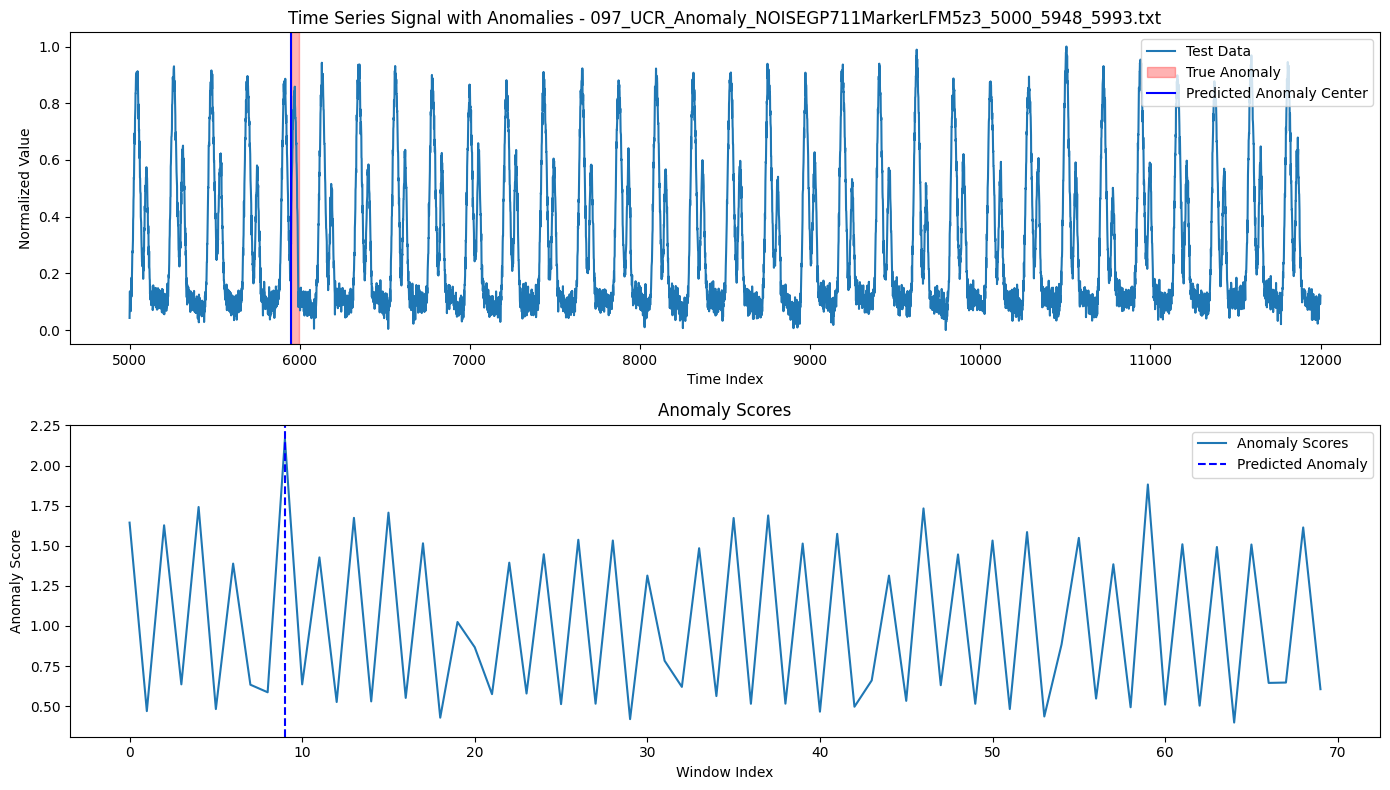

Processing file: 012_UCR_Anomaly_DISTORTEDECG2_15000_16000_16100.txt
Processing file: 246_UCR_Anomaly_tilt12755mtable_100211_270800_271070.txt
Processing file: 107_UCR_Anomaly_NOISEinsectEPG3_5200_7000_7050.txt
Processing file: 120_UCR_Anomaly_ECG2_15000_16000_16100.txt
Processing file: 134_UCR_Anomaly_InternalBleeding15_1700_5684_5854.txt
Correct prediction for 134_UCR_Anomaly_InternalBleeding15_1700_5684_5854.txt.


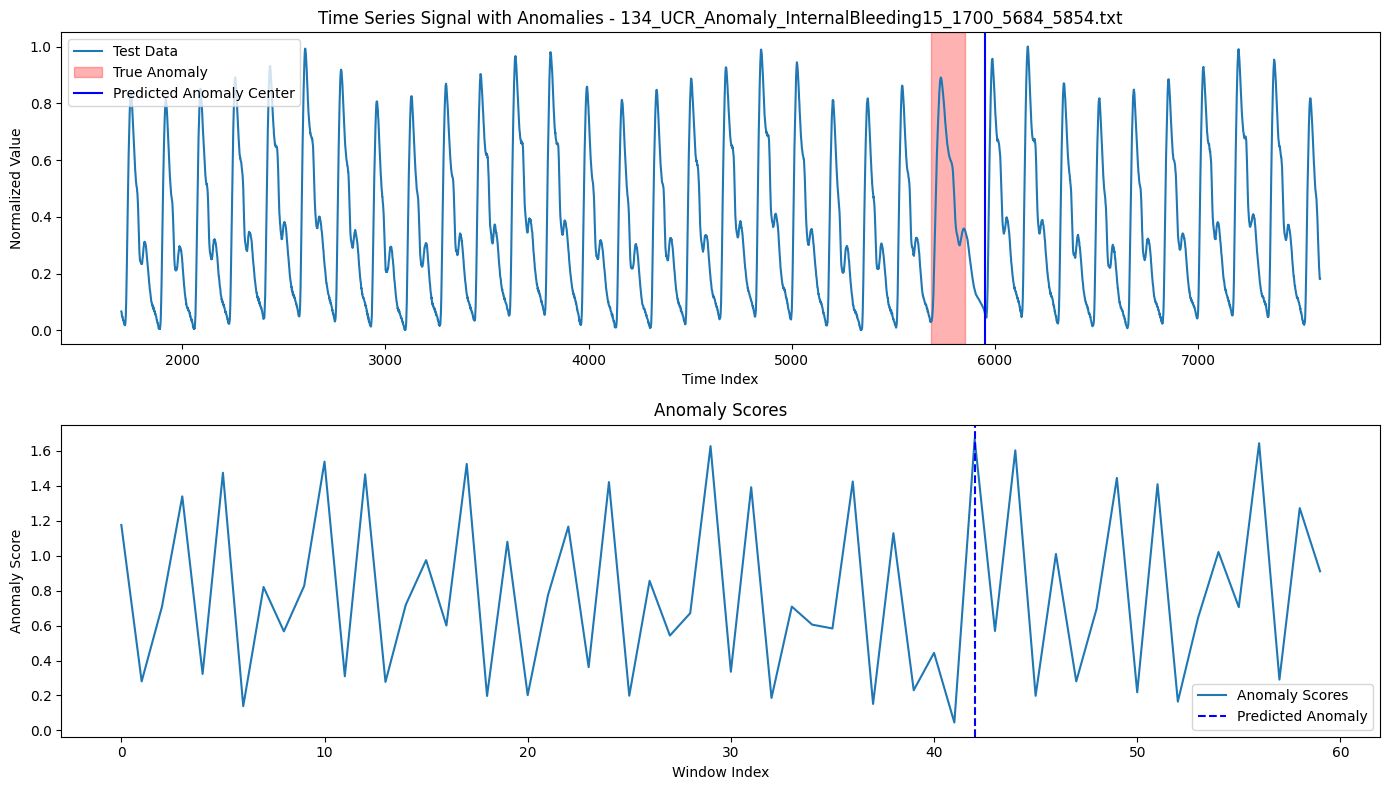

Processing file: 004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt
Correct prediction for 004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt.


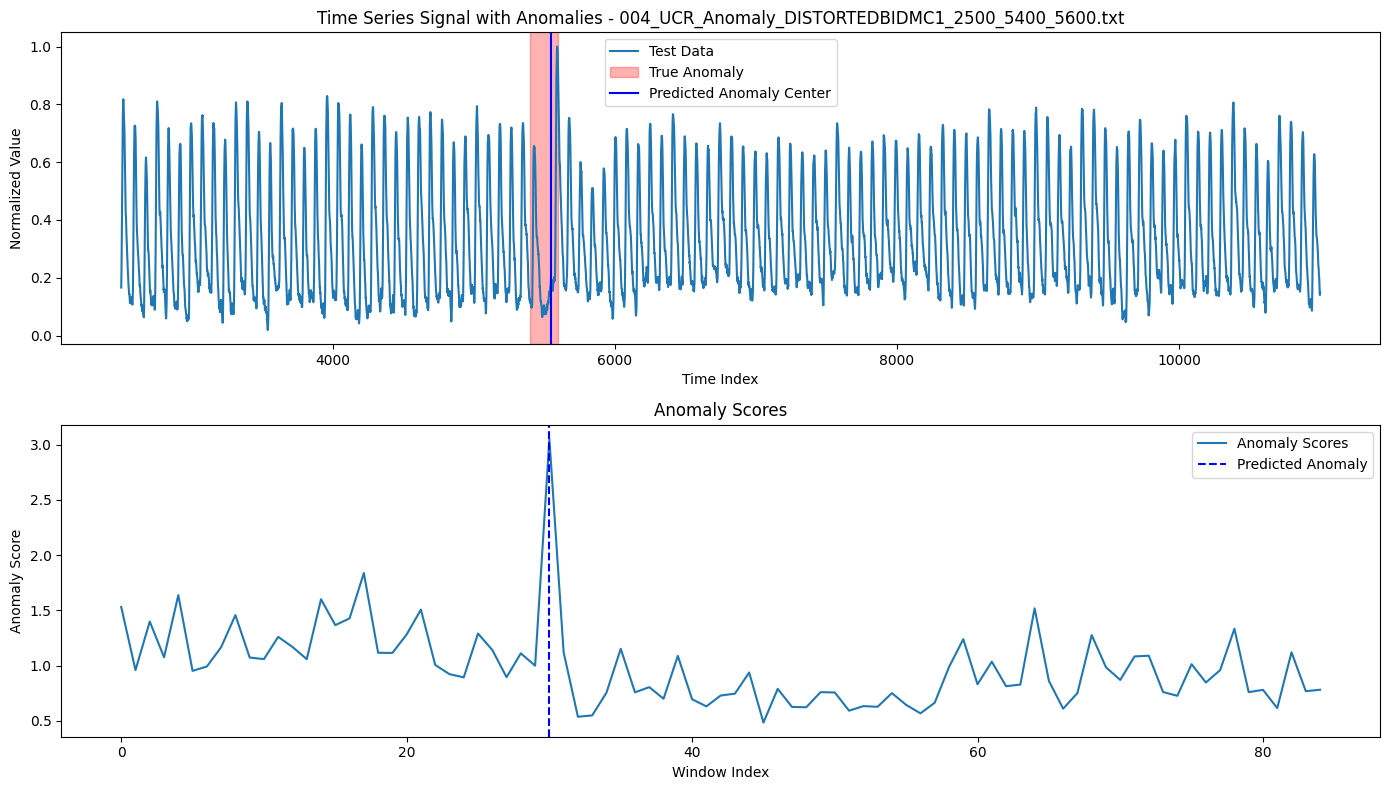

Processing file: 207_UCR_Anomaly_CHARISten_3165_26929_26989.txt
Skipping 207_UCR_Anomaly_CHARISten_3165_26929_26989.txt due to insufficient data for reshaping.
Processing file: 073_UCR_Anomaly_DISTORTEDpark3m_60000_72150_72495.txt
Processing file: 008_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature4_4000_5549_5597.txt
Processing file: 105_UCR_Anomaly_NOISEgait3_24500_59900_60500.txt
Processing file: 068_UCR_Anomaly_DISTORTEDinsectEPG4_1300_6508_6558.txt
Processing file: 139_UCR_Anomaly_InternalBleeding20_2700_5759_5919.txt
Processing file: 017_UCR_Anomaly_DISTORTEDECG4_5000_17000_17100.txt
Processing file: 196_UCR_Anomaly_sel840mECG2_20000_49370_49740.txt
Processing file: 086_UCR_Anomaly_DISTORTEDsddb49_20000_67950_68200.txt
Processing file: 085_UCR_Anomaly_DISTORTEDs20101m_10000_35774_35874.txt
Processing file: 217_UCR_Anomaly_STAFFIIIDatabase_38211_150720_151370.txt
Processing file: 211_UCR_Anomaly_Italianpowerdemand_38113_39240_39336.txt
Processing file: 181_UCR_Anomaly_park3m_60000_7215

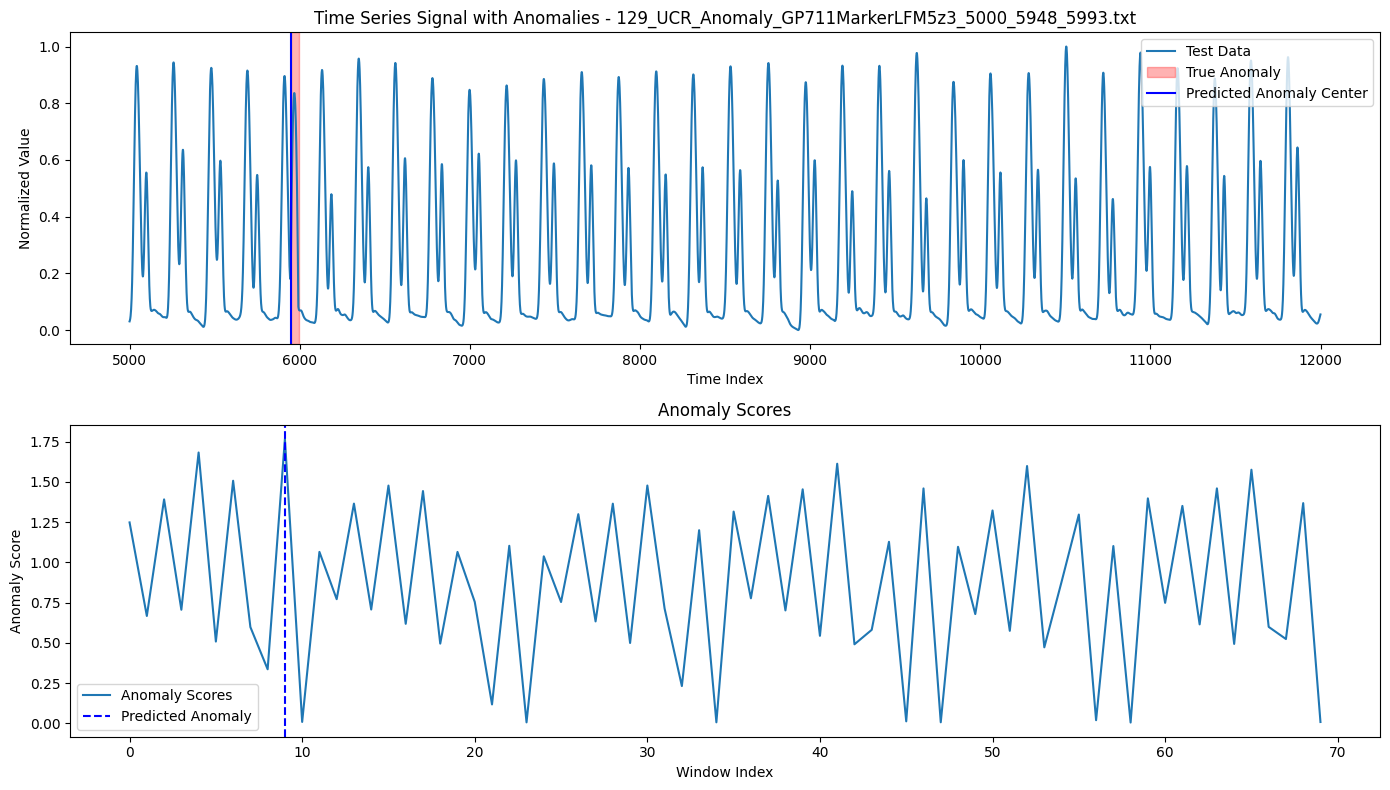

Processing file: 245_UCR_Anomaly_tilt12754table_100211_270800_271070.txt
Processing file: 234_UCR_Anomaly_mit14157longtermecg_18913_24600_24601.txt
Processing file: 161_UCR_Anomaly_WalkingAceleration1_1500_2764_2995.txt
Processing file: 067_UCR_Anomaly_DISTORTEDinsectEPG3_5200_7000_7050.txt
Processing file: 170_UCR_Anomaly_gaitHunt1_18500_33070_33180.txt
Processing file: 118_UCR_Anomaly_CIMIS44AirTemperature6_4000_6006_6054.txt
Processing file: 143_UCR_Anomaly_InternalBleeding8_2500_5865_5974.txt
Processing file: 155_UCR_Anomaly_PowerDemand4_18000_24005_24077.txt
Processing file: 162_UCR_Anomaly_WalkingAceleration5_2700_5920_5979.txt
Correct prediction for 162_UCR_Anomaly_WalkingAceleration5_2700_5920_5979.txt.


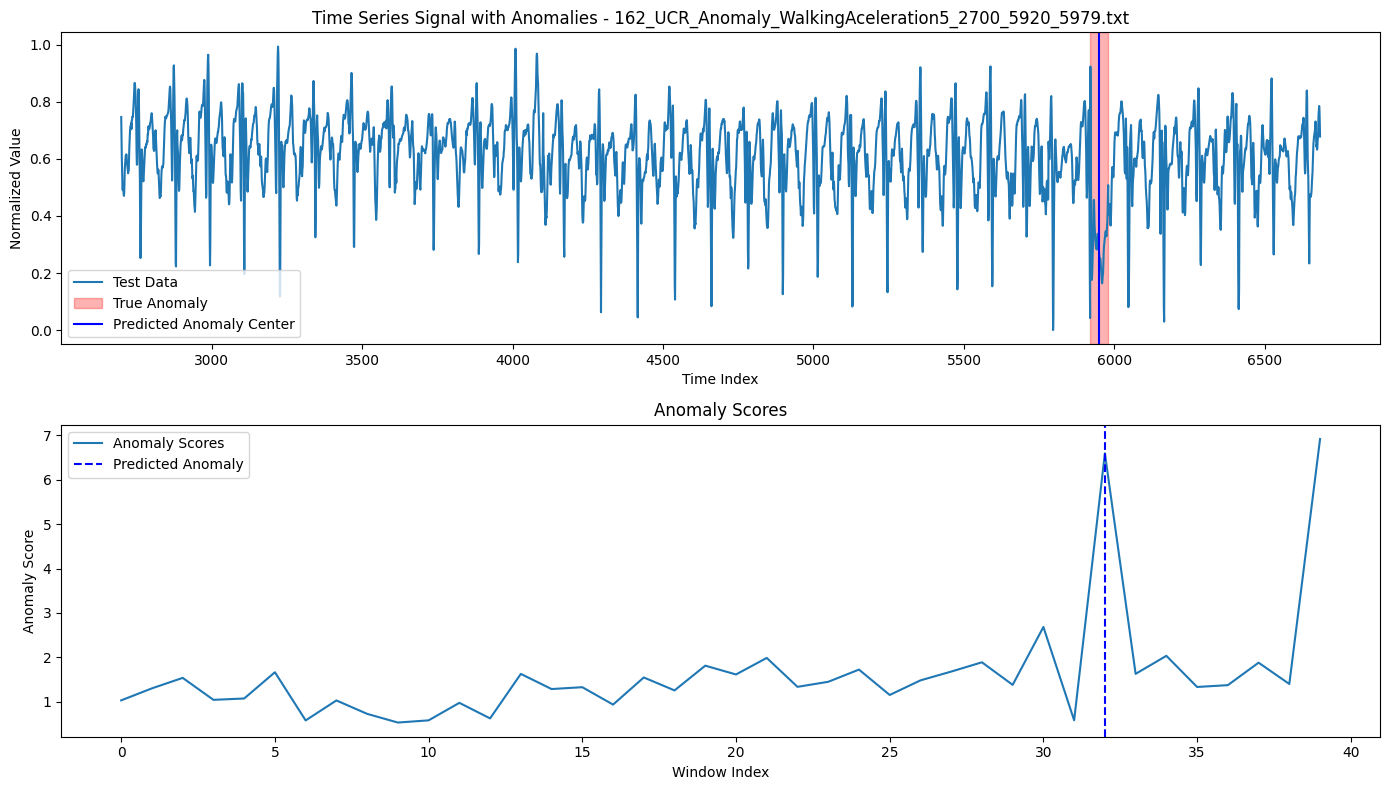

Processing file: 191_UCR_Anomaly_resperation9_38000_143411_143511.txt
Processing file: 034_UCR_Anomaly_DISTORTEDInternalBleeding6_1500_3474_3629.txt
Correct prediction for 034_UCR_Anomaly_DISTORTEDInternalBleeding6_1500_3474_3629.txt.


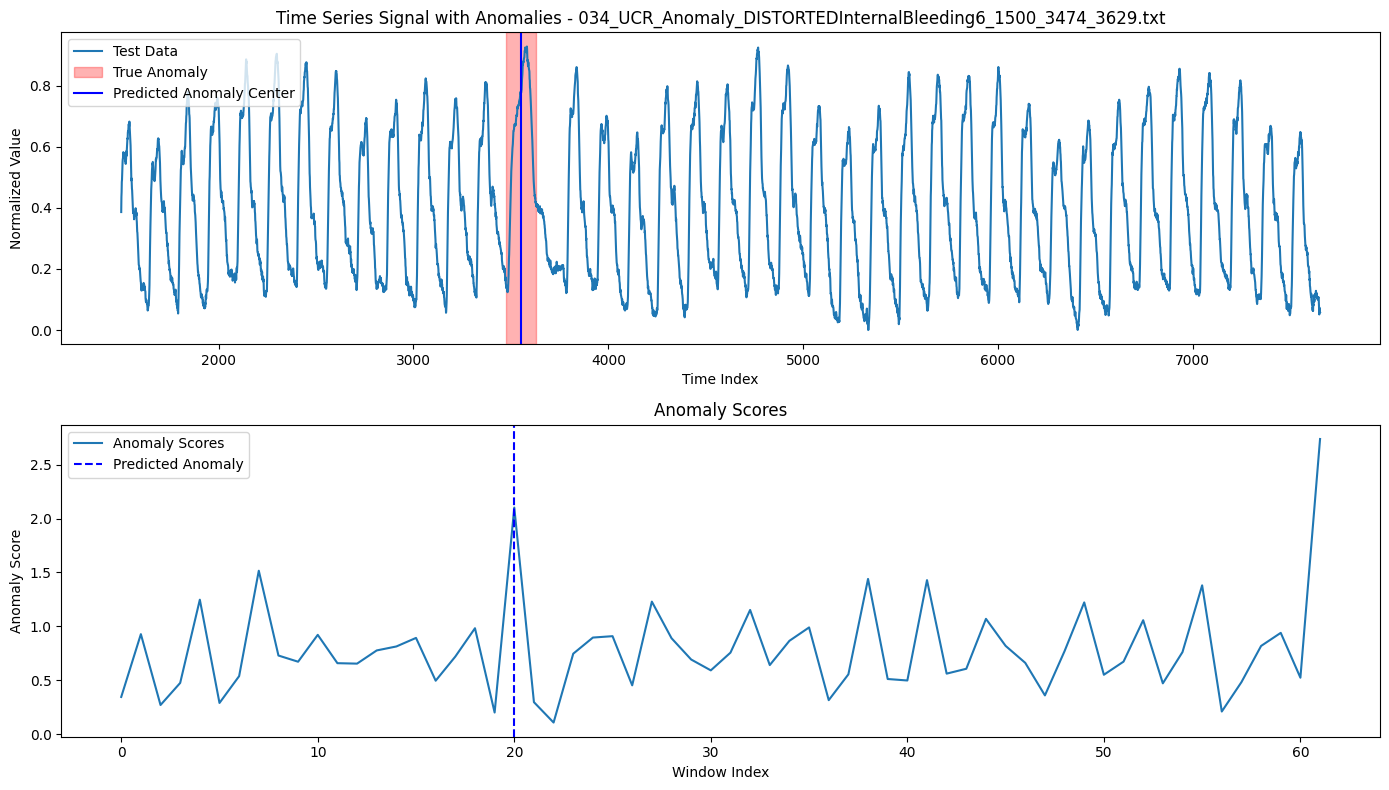

Processing file: 110_UCR_Anomaly_2sddb40_35000_56600_56900.txt
Processing file: 009_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature5_4000_4852_4900.txt
Processing file: 133_UCR_Anomaly_InternalBleeding14_2800_5607_5634.txt
Processing file: 088_UCR_Anomaly_DISTORTEDsel840mECG2_20000_49370_49740.txt
Processing file: 203_UCR_Anomaly_CHARISfive_10500_10995_11028.txt
Processing file: 010_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature6_4000_6006_6054.txt
Processing file: 089_UCR_Anomaly_DISTORTEDtiltAPB1_100000_114283_114350.txt
Processing file: 037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt
Correct prediction for 037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt.


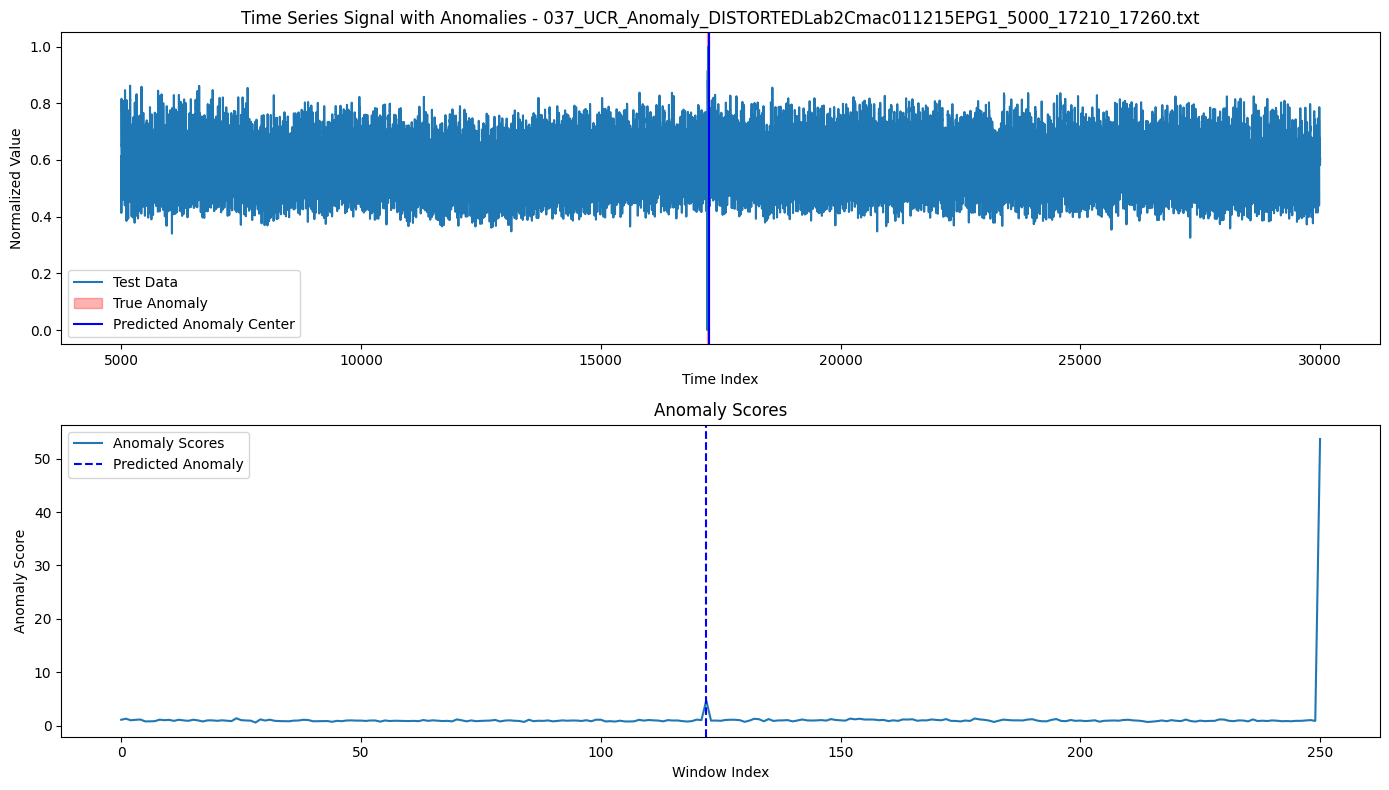

Processing file: 249_UCR_Anomaly_weallwalk_2753_8285_8315.txt
Processing file: 081_UCR_Anomaly_DISTORTEDresperation3_45000_158250_158251.txt
Processing file: 128_UCR_Anomaly_GP711MarkerLFM5z2_5000_7175_7388.txt
Processing file: 201_UCR_Anomaly_CHARISfive_10000_17001_17016.txt
Correct prediction for 201_UCR_Anomaly_CHARISfive_10000_17001_17016.txt.


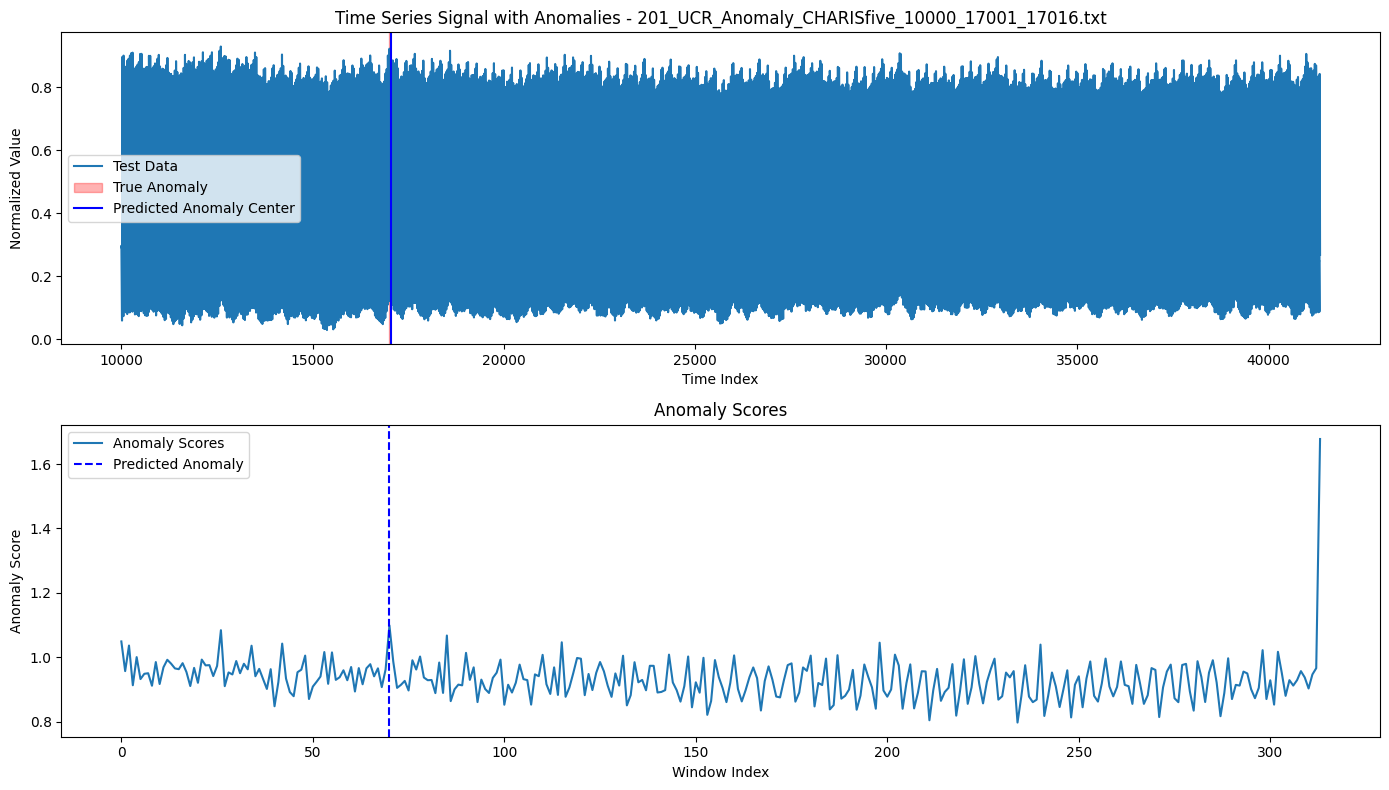

Processing file: 071_UCR_Anomaly_DISTORTEDltstdbs30791AS_23000_52600_52800.txt
Correct prediction for 071_UCR_Anomaly_DISTORTEDltstdbs30791AS_23000_52600_52800.txt.


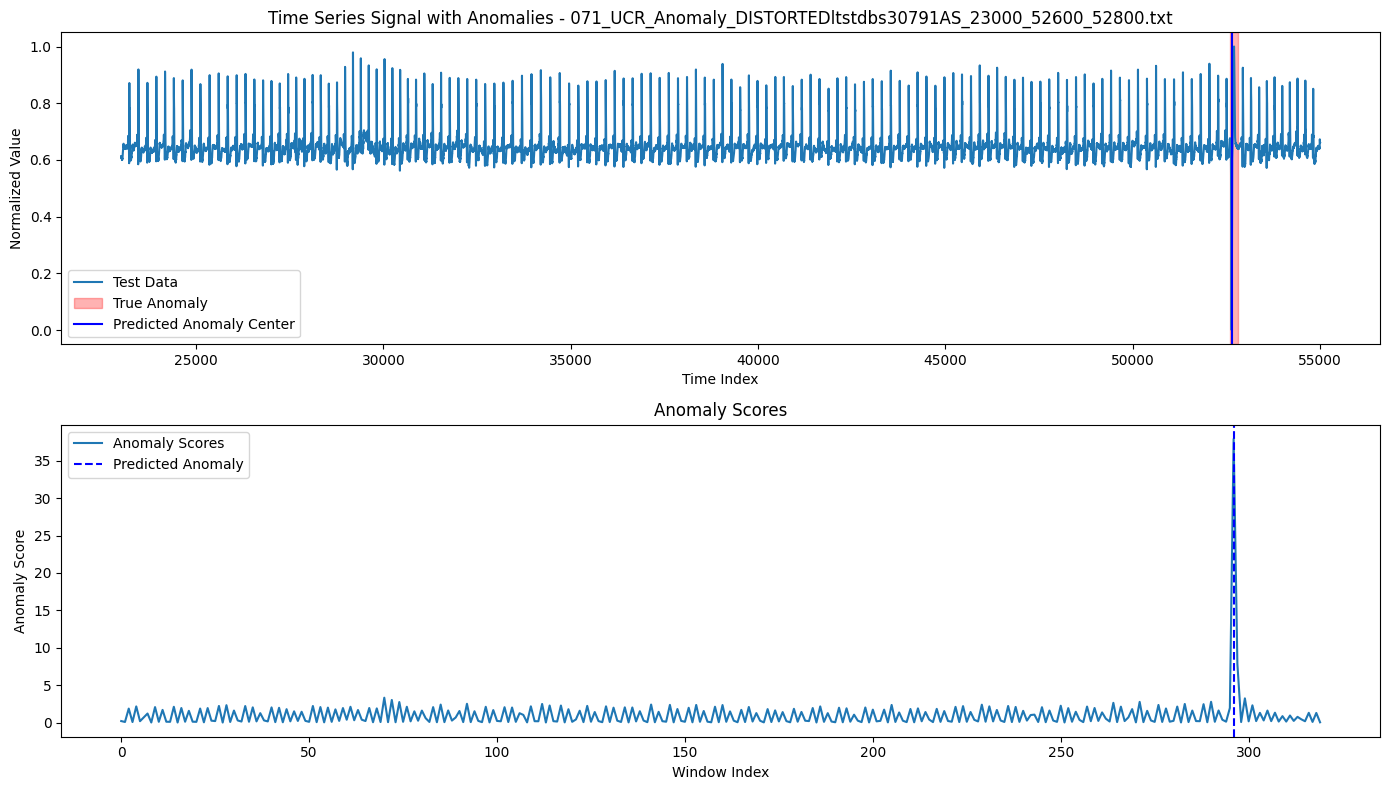

Processing file: 083_UCR_Anomaly_DISTORTEDresperation9_38000_143411_143511.txt
Processing file: 166_UCR_Anomaly_apneaecg_10000_12240_12308.txt
Processing file: 235_UCR_Anomaly_mit14157longtermecg_18913_75450_75451.txt
Processing file: 230_UCR_Anomaly_mit14134longtermecg_19363_19510_19610.txt
Processing file: 091_UCR_Anomaly_DISTORTEDtiltAPB3_40000_114000_114370.txt
Processing file: 148_UCR_Anomaly_Lab2Cmac011215EPG4_6000_17390_17520.txt
Processing file: 049_UCR_Anomaly_DISTORTEDTkeepFirstMARS_3500_5365_5380.txt
Processing file: 175_UCR_Anomaly_insectEPG3_5200_7000_7050.txt
Processing file: 038_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG2_5000_27862_27932.txt
Processing file: 236_UCR_Anomaly_mit14157longtermecg_19313_46350_46390.txt
Processing file: 167_UCR_Anomaly_gait1_20000_38500_38800.txt
Processing file: 243_UCR_Anomaly_tilt12744mtable_100000_203355_203400.txt
Skipping 243_UCR_Anomaly_tilt12744mtable_100000_203355_203400.txt due to insufficient data for reshaping.
Processing file: 187_U

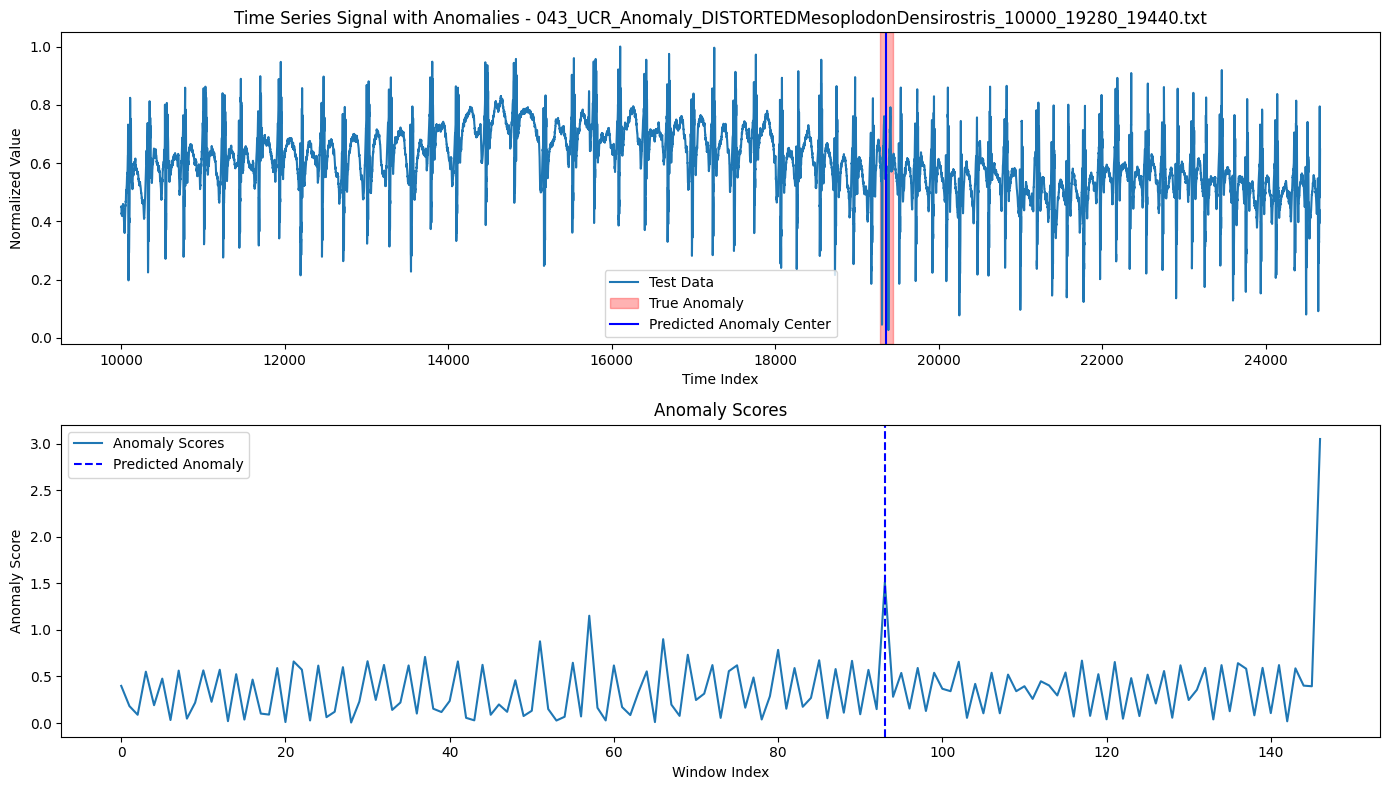

Processing file: 174_UCR_Anomaly_insectEPG2_3700_8000_8025.txt
Processing file: 182_UCR_Anomaly_qtdbSel1005V_4000_12400_12800.txt
Processing file: 153_UCR_Anomaly_PowerDemand2_14000_23357_23717.txt
Processing file: 014_UCR_Anomaly_DISTORTEDECG3_8000_17000_17100.txt
Processing file: 095_UCR_Anomaly_NOISECIMIS44AirTemperature4_4000_5549_5597.txt
Processing file: 237_UCR_Anomaly_mit14157longtermecg_19313_89560_90370.txt
Processing file: 238_UCR_Anomaly_mit14157longtermecg_21311_72600_72780.txt
Processing file: 078_UCR_Anomaly_DISTORTEDresperation1_100000_110260_110412.txt
Processing file: 156_UCR_Anomaly_TkeepFifthMARS_3500_5988_6085.txt
Correct prediction for 156_UCR_Anomaly_TkeepFifthMARS_3500_5988_6085.txt.


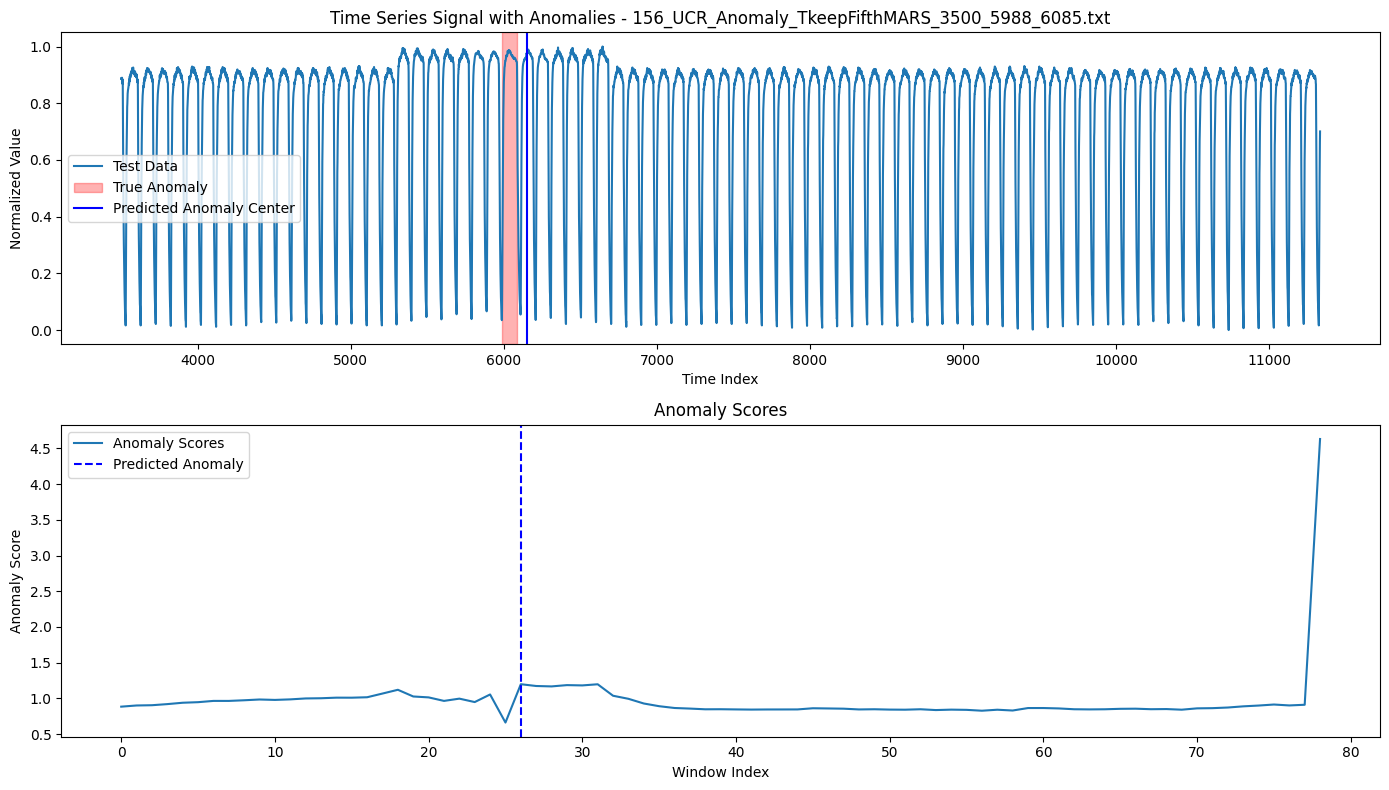

Processing file: 116_UCR_Anomaly_CIMIS44AirTemperature4_4000_5549_5597.txt
Processing file: 011_UCR_Anomaly_DISTORTEDECG1_10000_11800_12100.txt
Correct prediction for 011_UCR_Anomaly_DISTORTEDECG1_10000_11800_12100.txt.


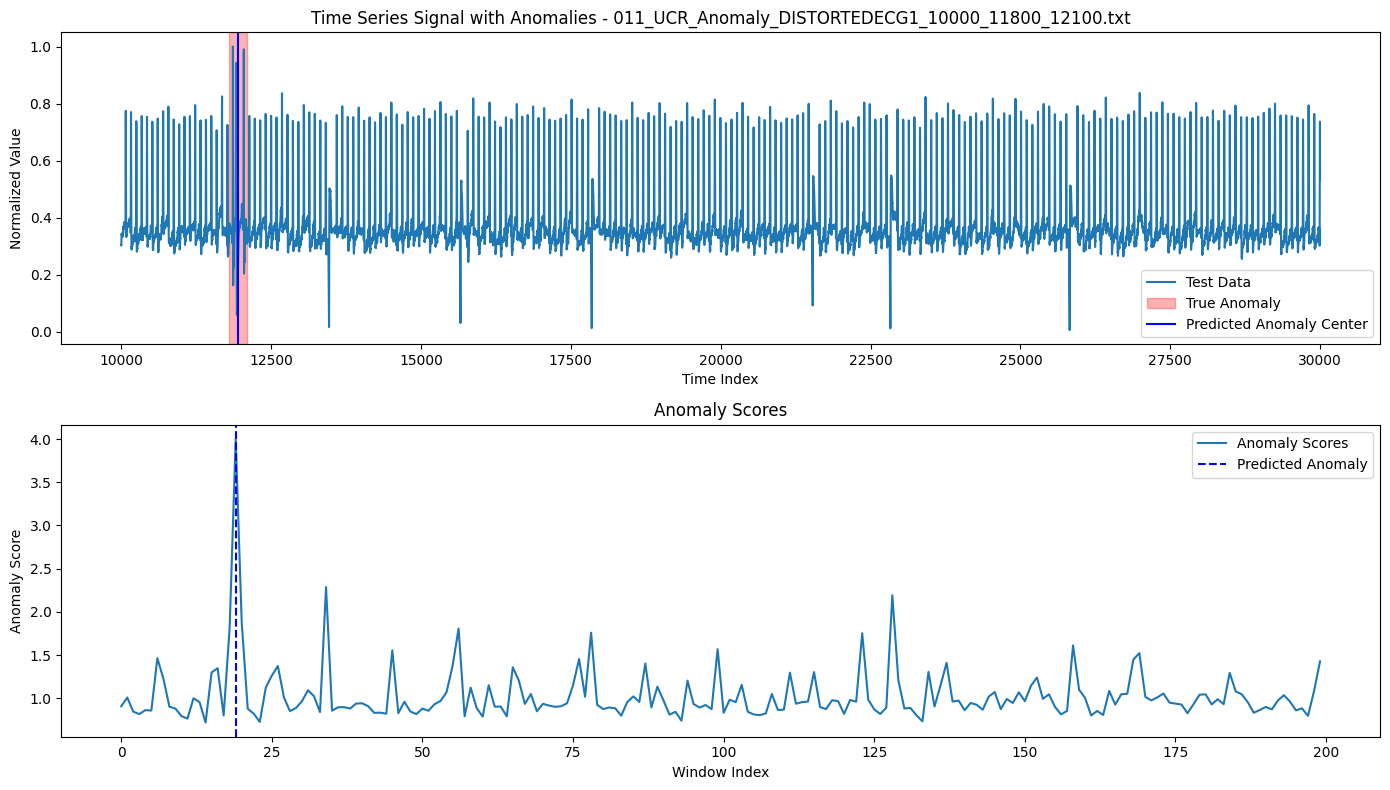

Processing file: 007_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature3_4000_6520_6544.txt
Processing file: 169_UCR_Anomaly_gait3_24500_59900_60500.txt
Processing file: 218_UCR_Anomaly_STAFFIIIDatabase_41117_210720_211370.txt
Processing file: 054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979.txt
Correct prediction for 054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979.txt.


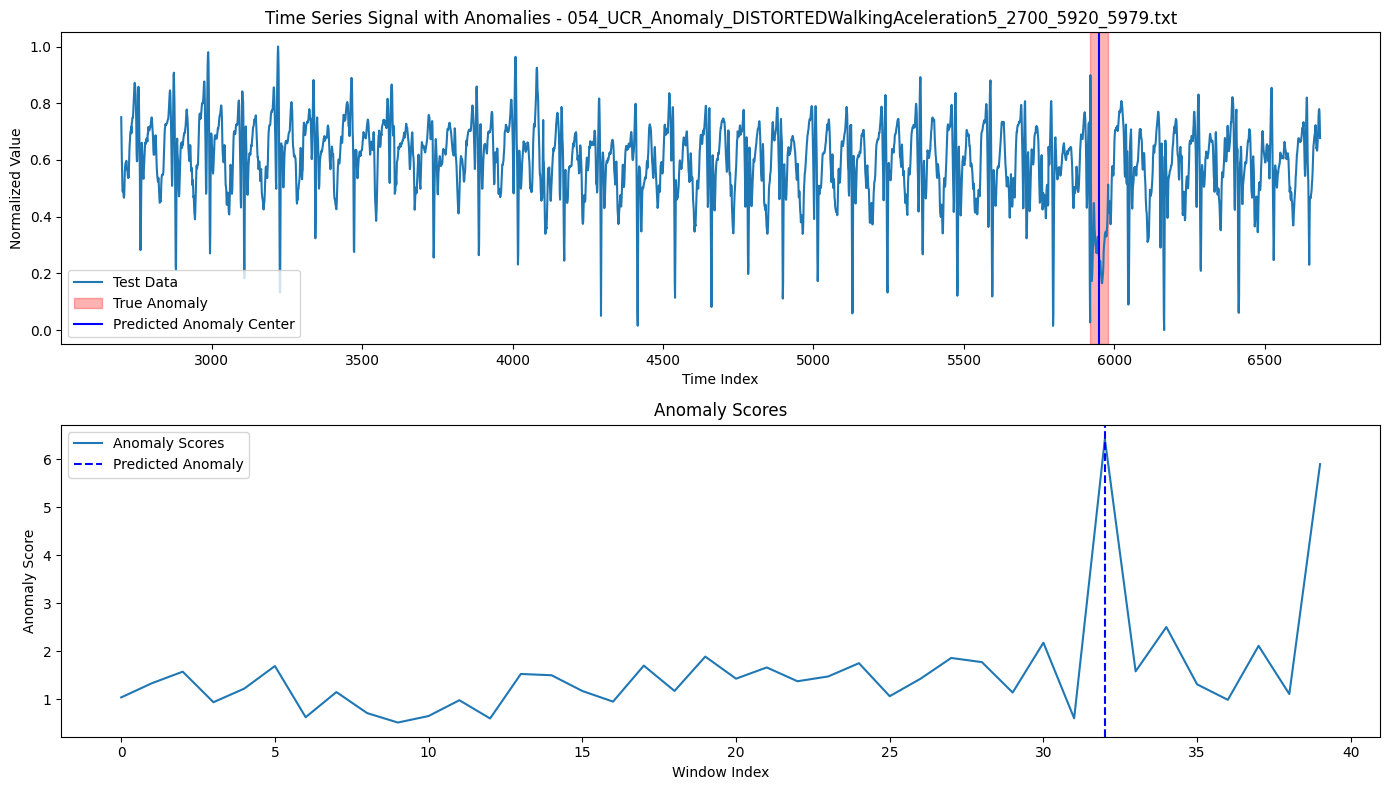

Processing file: 209_UCR_Anomaly_Fantasia_19000_26970_27270.txt
Processing file: 046_UCR_Anomaly_DISTORTEDPowerDemand3_16000_23405_23477.txt
Processing file: 025_UCR_Anomaly_DISTORTEDInternalBleeding14_2800_5607_5634.txt
Processing file: 094_UCR_Anomaly_NOISEBIDMC1_2500_5400_5600.txt
Correct prediction for 094_UCR_Anomaly_NOISEBIDMC1_2500_5400_5600.txt.


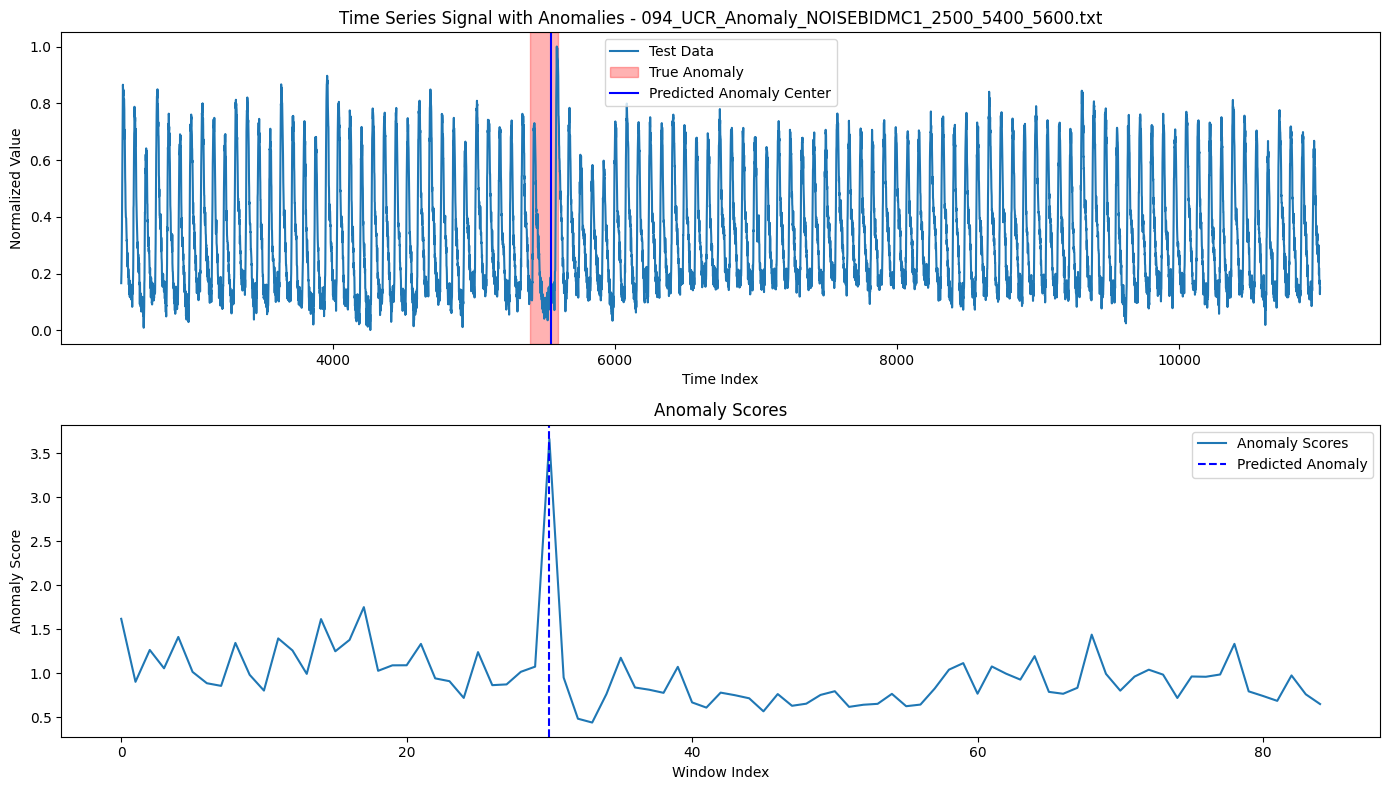

Processing file: 142_UCR_Anomaly_InternalBleeding6_1500_3474_3629.txt
Correct prediction for 142_UCR_Anomaly_InternalBleeding6_1500_3474_3629.txt.


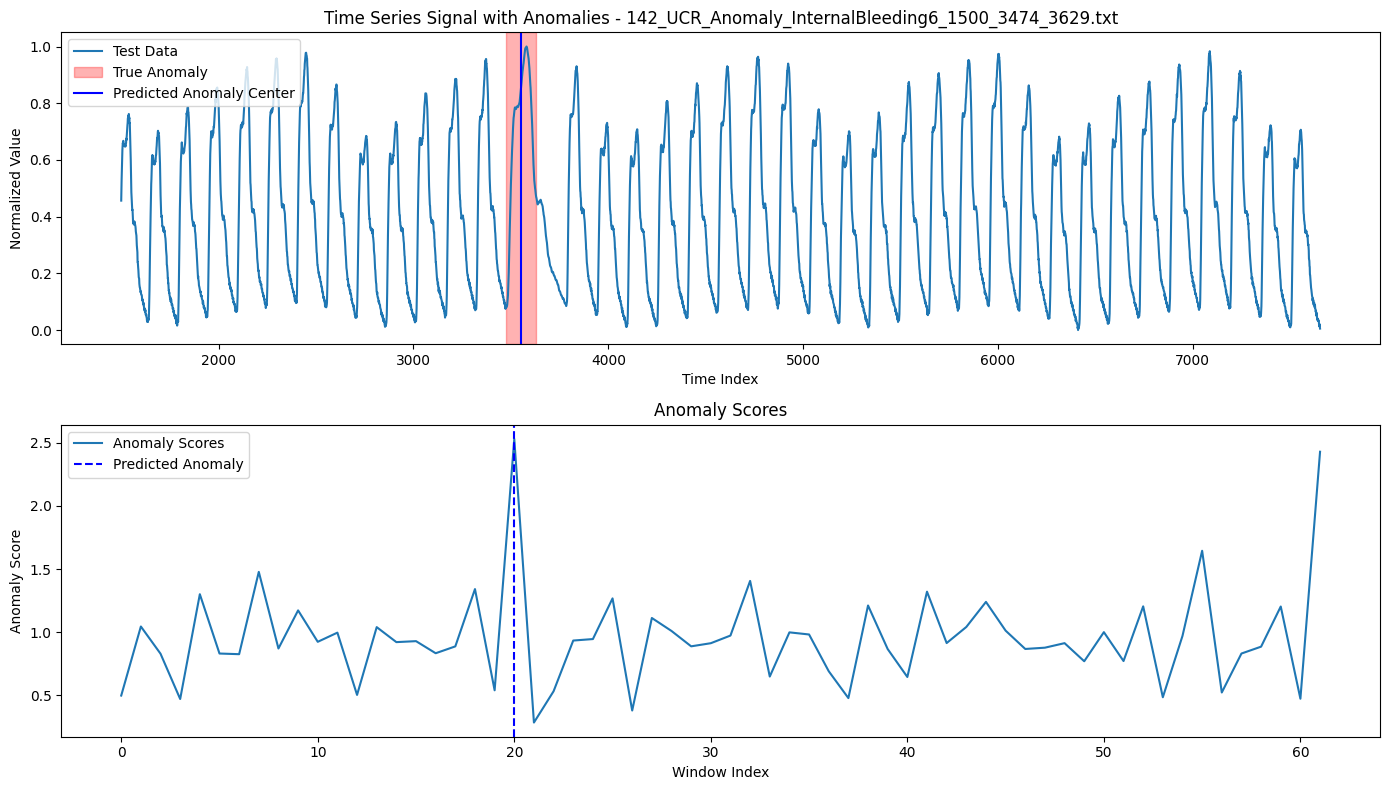

Processing file: 159_UCR_Anomaly_TkeepSecondMARS_3500_9330_9340.txt
Processing file: 206_UCR_Anomaly_CHARISten_25130_29080_29140.txt
Skipping 206_UCR_Anomaly_CHARISten_25130_29080_29140.txt due to insufficient data for reshaping.
Processing file: 138_UCR_Anomaly_InternalBleeding19_3000_4187_4197.txt
Processing file: 123_UCR_Anomaly_ECG4_5000_16800_17100.txt
Processing file: 135_UCR_Anomaly_InternalBleeding16_1200_4187_4199.txt
Processing file: 192_UCR_Anomaly_s20101mML2_12000_35774_35874.txt
Correct prediction for 192_UCR_Anomaly_s20101mML2_12000_35774_35874.txt.


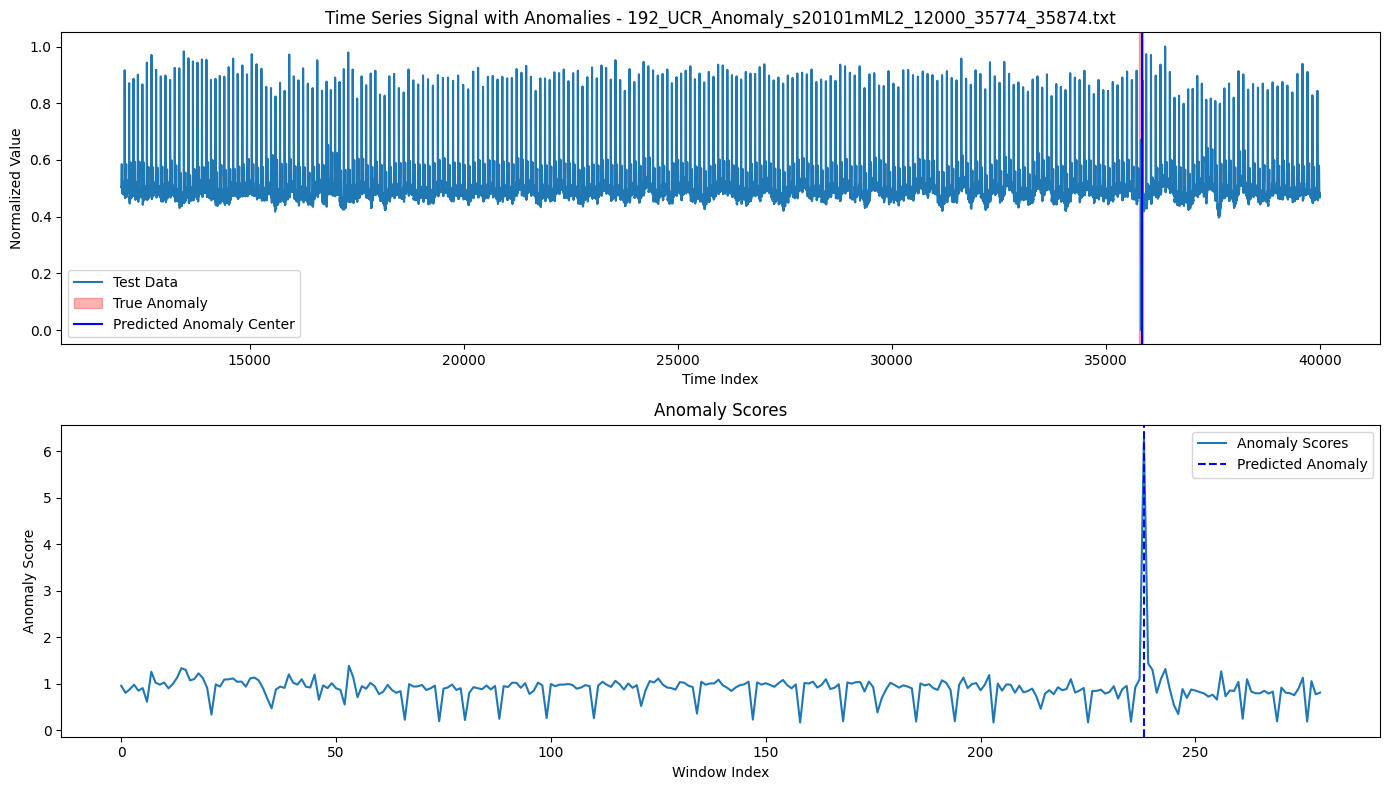

Processing file: 185_UCR_Anomaly_resperation11_58000_110800_110801.txt
Processing file: 115_UCR_Anomaly_CIMIS44AirTemperature3_4000_6520_6544.txt
Processing file: 140_UCR_Anomaly_InternalBleeding4_1000_4675_5033.txt
Processing file: 101_UCR_Anomaly_NOISELab2Cmac011215EPG4_6000_17390_17520.txt
Processing file: 080_UCR_Anomaly_DISTORTEDresperation2_30000_168250_168251.txt
Processing file: 119_UCR_Anomaly_ECG1_10000_11800_12100.txt
Correct prediction for 119_UCR_Anomaly_ECG1_10000_11800_12100.txt.


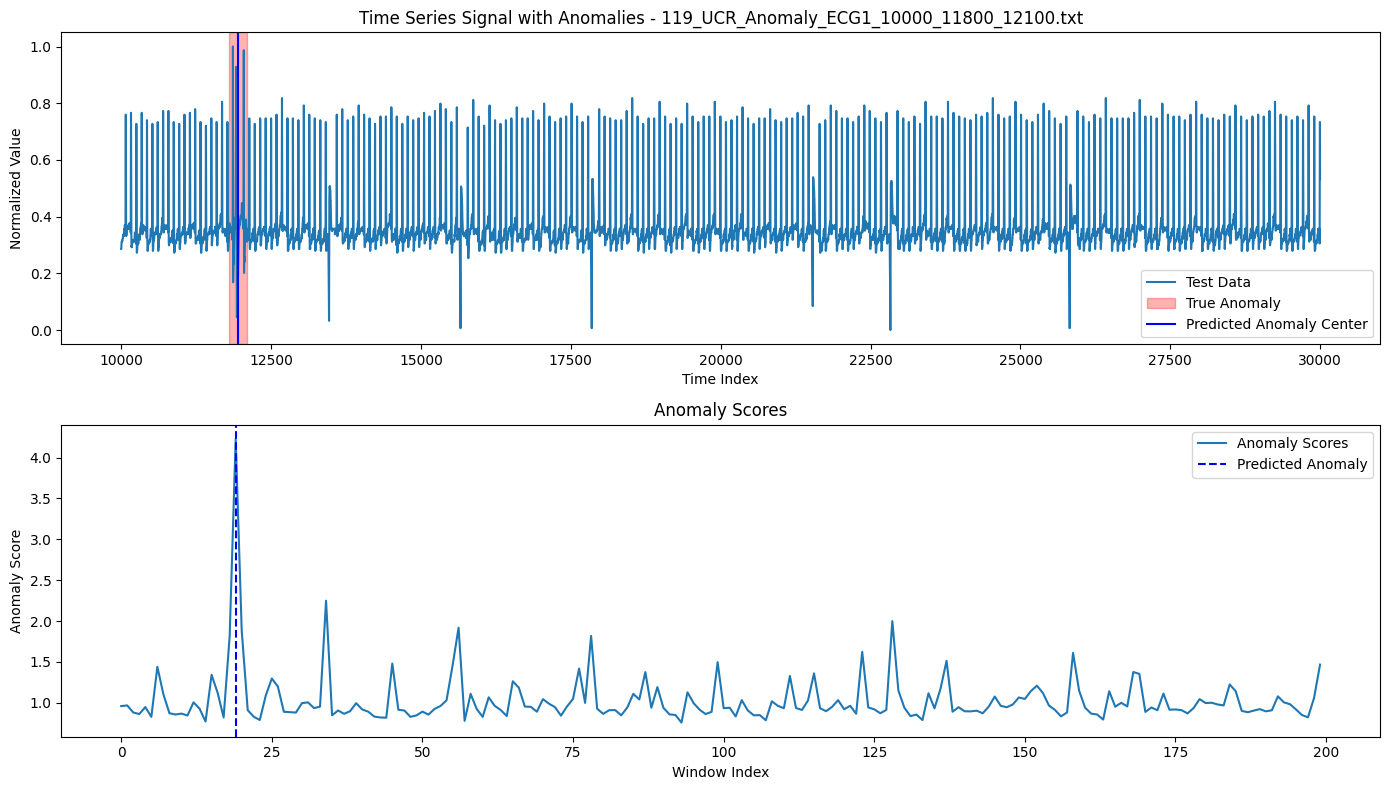

Processing file: 200_UCR_Anomaly_tiltAPB4_20000_67995_67996.txt
Processing file: 090_UCR_Anomaly_DISTORTEDtiltAPB2_50000_124159_124985.txt
Processing file: 177_UCR_Anomaly_insectEPG5_3200_8500_8501.txt
Processing file: 205_UCR_Anomaly_CHARISfive_9812_28995_29085.txt
Skipping 205_UCR_Anomaly_CHARISfive_9812_28995_29085.txt due to insufficient data for reshaping.
Processing file: 061_UCR_Anomaly_DISTORTEDgait3_24500_59900_60500.txt
Processing file: 047_UCR_Anomaly_DISTORTEDPowerDemand4_18000_24005_24077.txt
Processing file: 117_UCR_Anomaly_CIMIS44AirTemperature5_4000_4852_4900.txt
Processing file: 145_UCR_Anomaly_Lab2Cmac011215EPG1_5000_17210_17260.txt
Correct prediction for 145_UCR_Anomaly_Lab2Cmac011215EPG1_5000_17210_17260.txt.


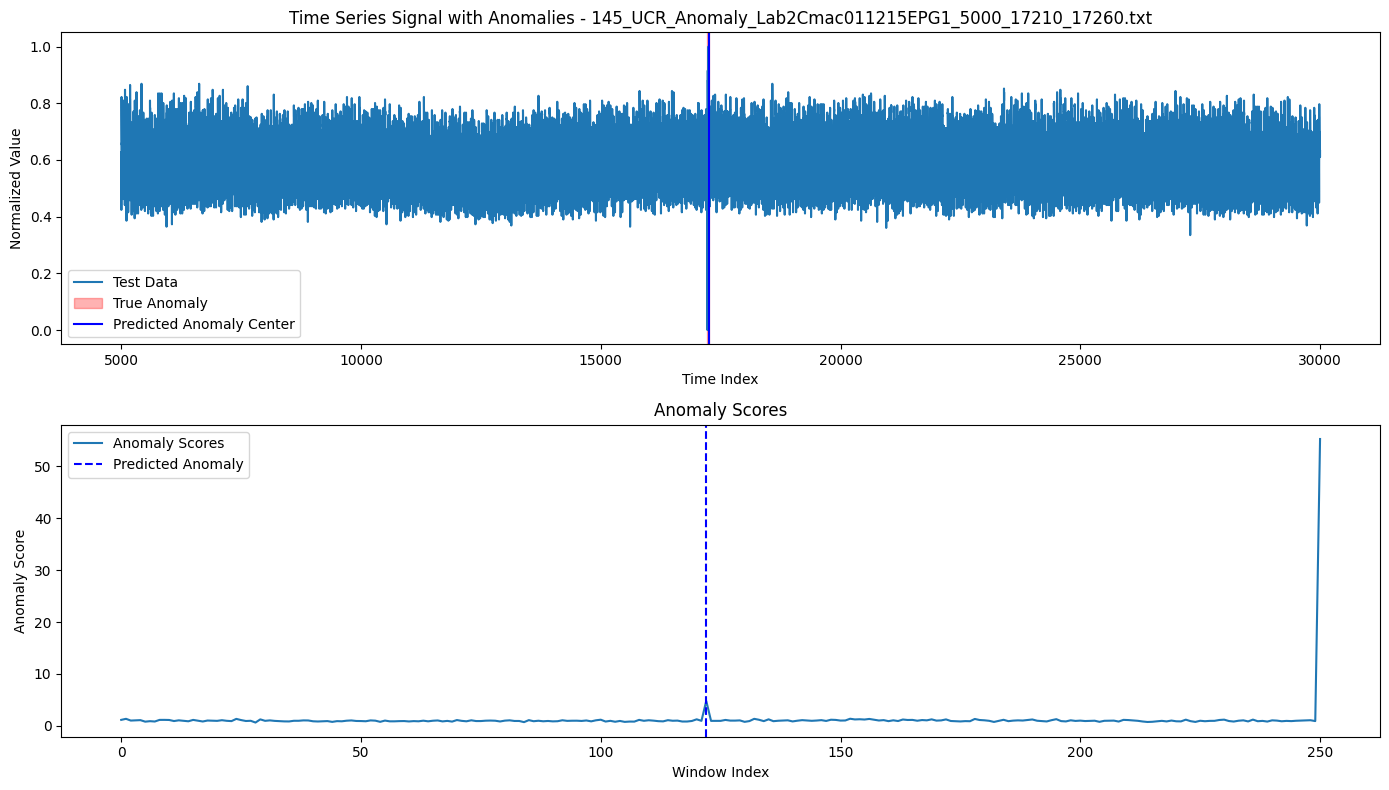

Processing file: 019_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z1_5000_6168_6212.txt
Processing file: 131_UCR_Anomaly_GP711MarkerLFM5z5_5000_8612_8716.txt
Processing file: 127_UCR_Anomaly_GP711MarkerLFM5z1_5000_6168_6212.txt
Correct prediction for 127_UCR_Anomaly_GP711MarkerLFM5z1_5000_6168_6212.txt.


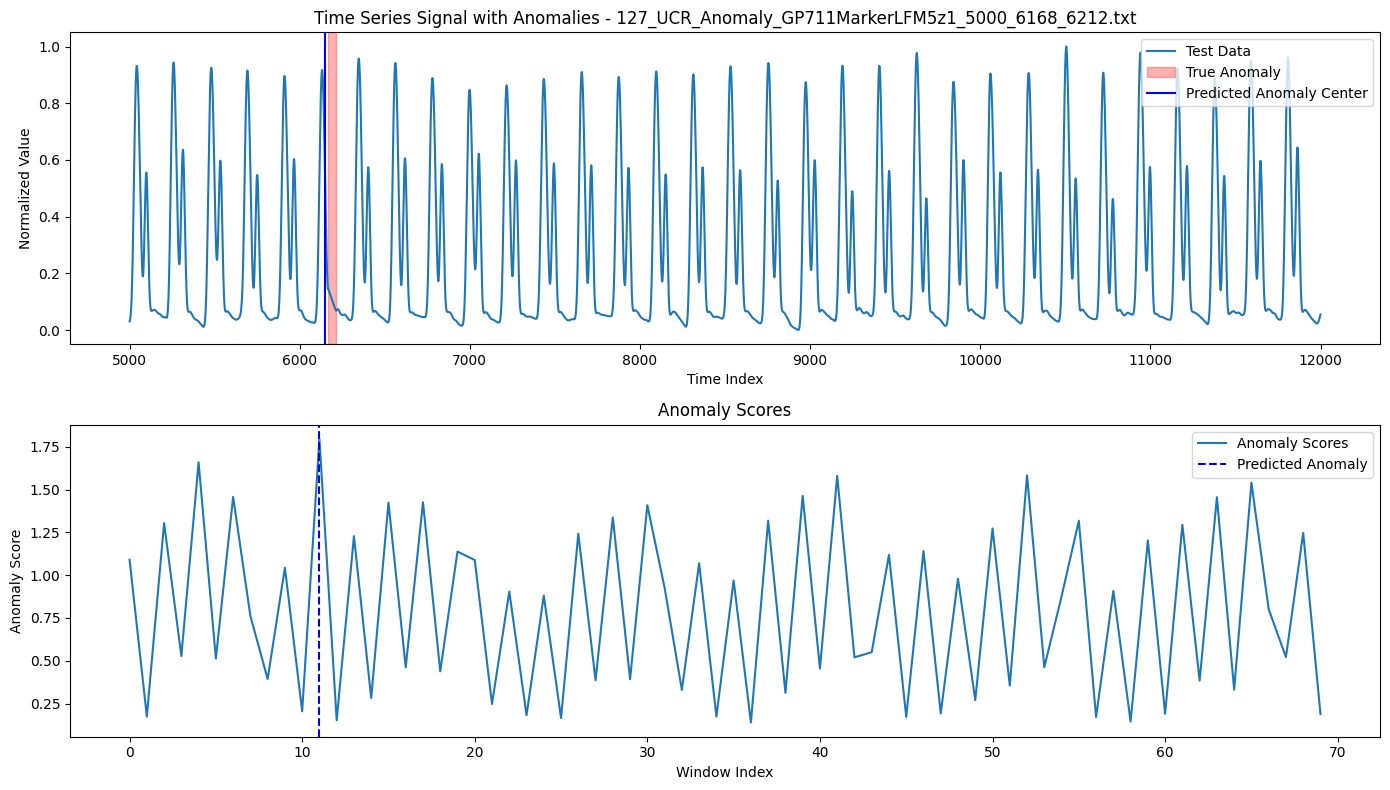

Processing file: 021_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z3_5000_5948_5993.txt
Processing file: 168_UCR_Anomaly_gait2_22000_46500_46800.txt
Correct prediction for 168_UCR_Anomaly_gait2_22000_46500_46800.txt.


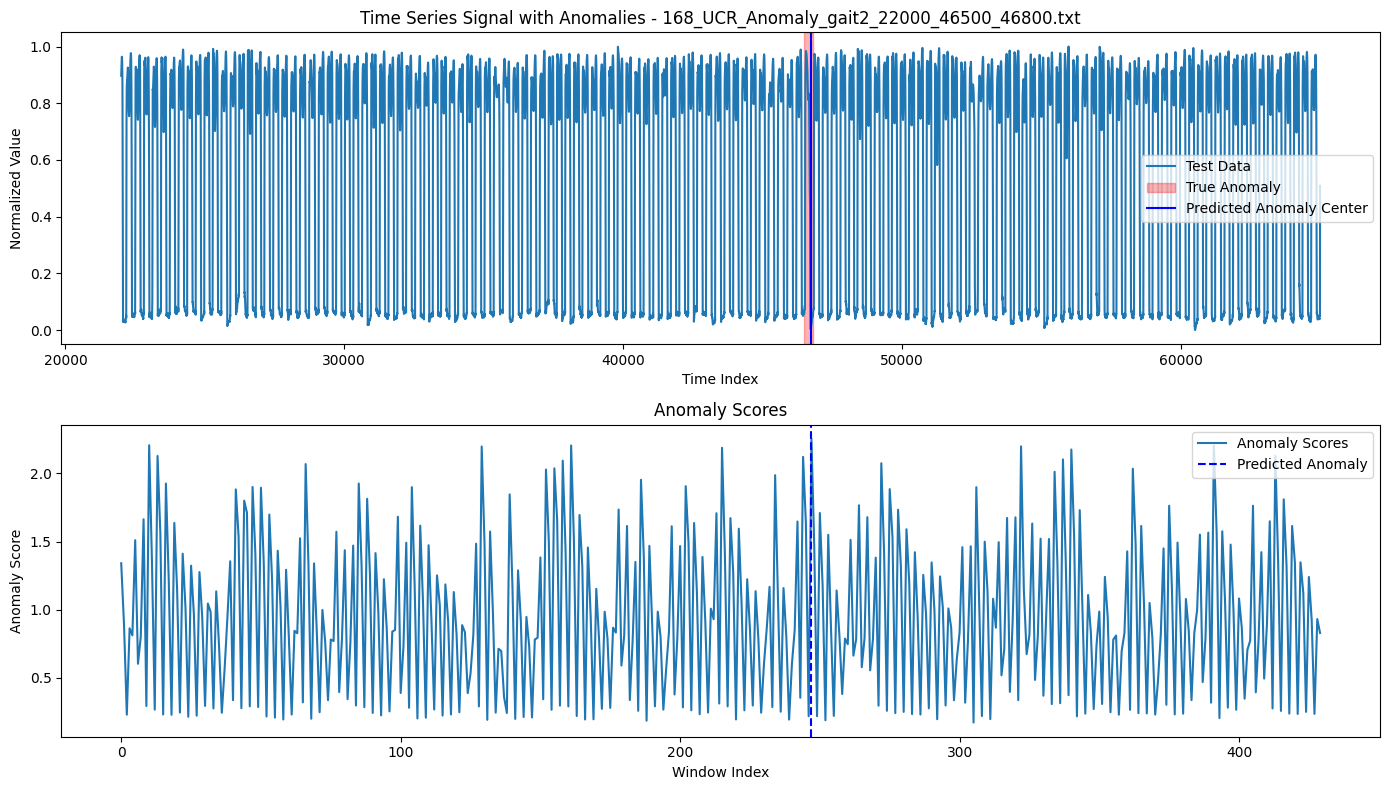

Processing file: 065_UCR_Anomaly_DISTORTEDinsectEPG1_3000_7000_7030.txt
Processing file: 154_UCR_Anomaly_PowerDemand3_16000_23405_23477.txt
Processing file: 072_UCR_Anomaly_DISTORTEDltstdbs30791ES_20000_52600_52800.txt
Processing file: 121_UCR_Anomaly_ECG3_15000_16000_16100.txt
Processing file: 076_UCR_Anomaly_DISTORTEDresperation10_48000_130700_131880.txt
Processing file: 029_UCR_Anomaly_DISTORTEDInternalBleeding18_2300_4485_4587.txt
Processing file: 248_UCR_Anomaly_weallwalk_2000_4702_4707.txt
Processing file: 239_UCR_Anomaly_taichidbS0715Master_190037_593450_593514.txt
Processing file: 024_UCR_Anomaly_DISTORTEDInternalBleeding10_3200_4526_4556.txt
Processing file: 195_UCR_Anomaly_sel840mECG1_17000_51370_51740.txt
Processing file: 188_UCR_Anomaly_resperation2_30000_168250_168251.txt
Processing file: 112_UCR_Anomaly_BIDMC1_2500_5400_5600.txt
Correct prediction for 112_UCR_Anomaly_BIDMC1_2500_5400_5600.txt.


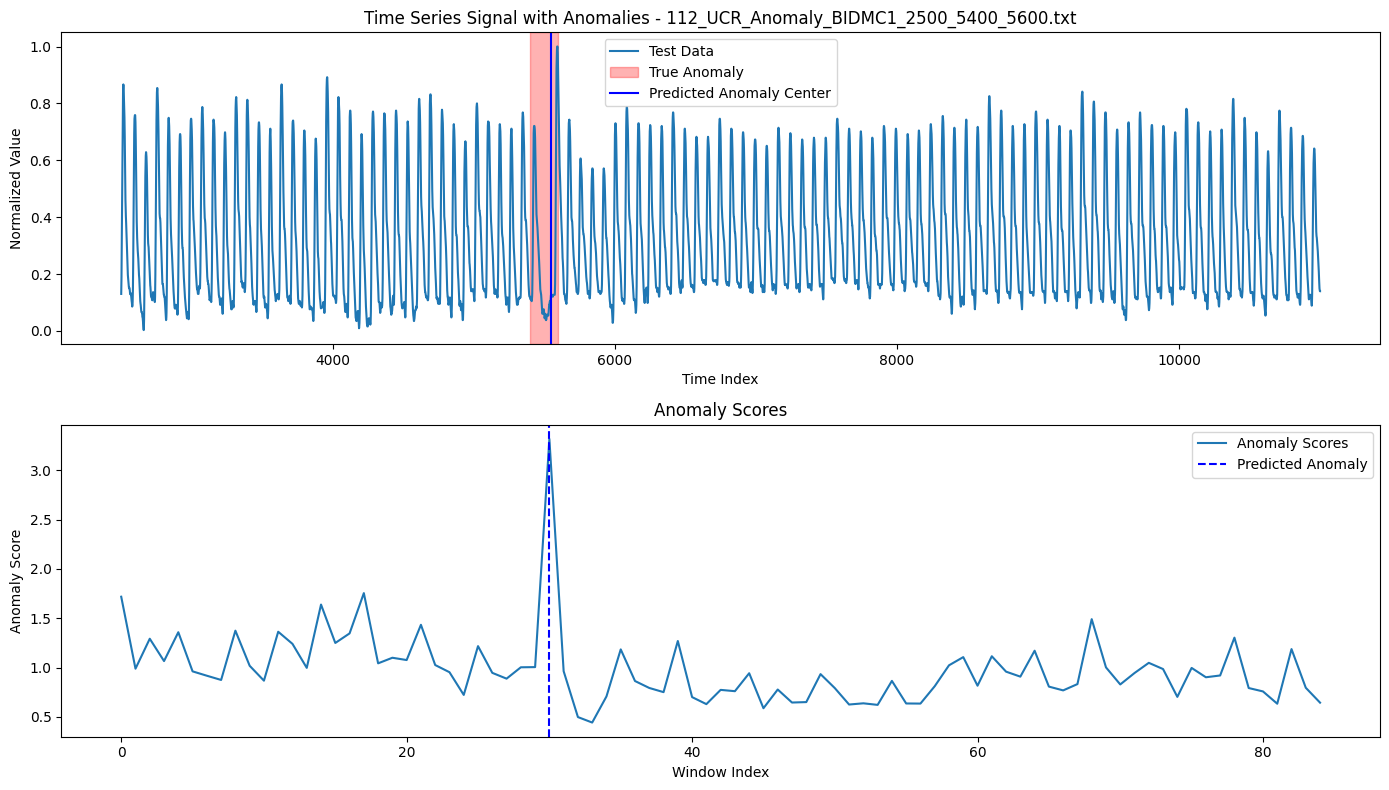

Processing file: 122_UCR_Anomaly_ECG3_8000_17000_17100.txt
Processing file: 100_UCR_Anomaly_NOISELab2Cmac011215EPG1_5000_17210_17260.txt
Correct prediction for 100_UCR_Anomaly_NOISELab2Cmac011215EPG1_5000_17210_17260.txt.


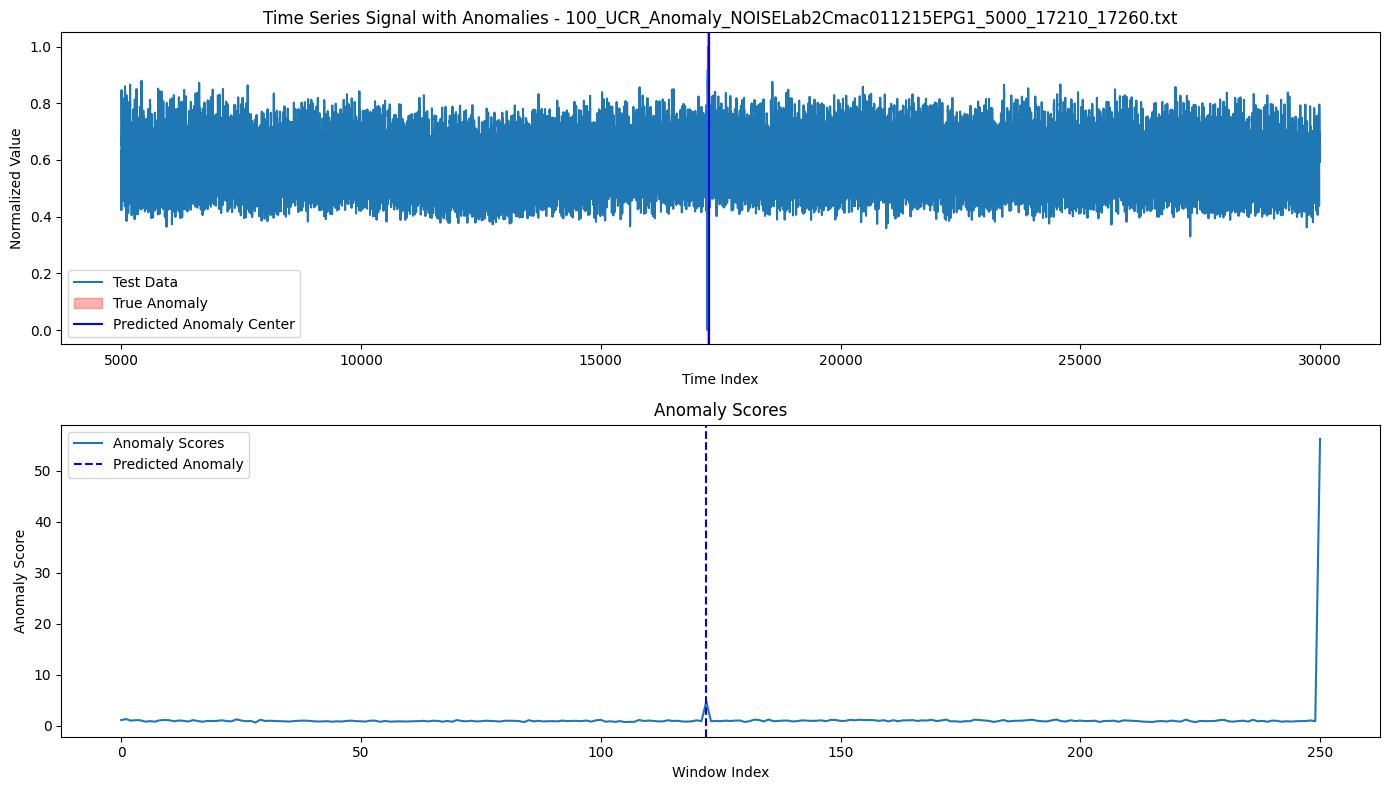

Processing file: 215_UCR_Anomaly_STAFFIIIDatabase_36276_106720_107370.txt
Processing file: 240_UCR_Anomaly_taichidbS0715Master_240030_884100_884200.txt
Processing file: 018_UCR_Anomaly_DISTORTEDECG4_8000_17000_17100.txt
Processing file: 197_UCR_Anomaly_tiltAPB1_100000_114283_114350.txt
Processing file: 050_UCR_Anomaly_DISTORTEDTkeepForthMARS_3500_5988_6085.txt
Processing file: 063_UCR_Anomaly_DISTORTEDgaitHunt2_18500_31200_31850.txt
Processing file: 075_UCR_Anomaly_DISTORTEDqtdbSel100MLII_4000_13400_13800.txt
Processing file: 132_UCR_Anomaly_InternalBleeding10_3200_4526_4556.txt
Processing file: 109_UCR_Anomaly_1sddb40_35000_52000_52620.txt
Processing file: 176_UCR_Anomaly_insectEPG4_1300_6508_6558.txt
Processing file: 098_UCR_Anomaly_NOISEInternalBleeding16_1200_4187_4199.txt


In [14]:

correct_predictions = 0
total_files = 0
anomaly_results = {anomaly_type: {'correct': 0, 'total': 0} for anomaly_type in anomaly_types_df['anomaly_type_2'].unique()}
all_true_labels = []
all_predicted_scores = []

#the following loop iterates over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        print(f"Processing file: {filename}")
        total_files += 1

        #loading the time series data
        ts = load_time_series(os.path.join(folder_path, filename))
        ts = (ts - np.min(ts)) / (np.max(ts) - np.min(ts))  #normalizing the data

        
        #parsing filename to get the anomaly information
        parts = filename[:-4].split('_')
        train_size = int(parts[-3])
        anomaly_start = int(parts[-2])
        anomaly_end = int(parts[-1])


        
        #the next two lines reshapes the data for the GRU model
        X_train = reshape_data(ts[:train_size])
        X_test = reshape_data(ts[train_size:])
        
        #the next line checks if the reshaped data is empty and skip if necessary
        if X_train.nelement() == 0 or X_test.nelement() == 0:
            print(f"Skipping {filename} due to insufficient data for reshaping.")
            continue


        #scaling the data
        X_train, X_test = scale_data(X_train.numpy(), X_test.numpy())
        X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)

        #start training the GRU model
        input_dim = X_train.size(2)
        hidden_dim = 64 #it is better to choose the hidden layer dimension with cross-validation
        num_layers = 2  #it is better to choose the number of layers with cross-validation
        model = GRUAutoencoder(input_dim, hidden_dim, num_layers)
        train_model(model, X_train, num_epochs=20, learning_rate=0.01) #it is better to choose the number of epochs and learning rate with cross-validation

        #now evaluate the model on test data ( the test section of each dataset)
        model.eval()
        with torch.no_grad():
            reconstructions = model(X_test)
            reconstructions = reconstructions[:, :X_test.size(1), :]  #ensuring the output matches the size of X_test
            loss = nn.MSELoss(reduction='none')(reconstructions, X_test).mean(dim=2)
            anomaly_scores = loss.mean(dim=1).numpy()
        
            #ignore the last two windows when calculating the highest anomaly score, because gru has a bias at the end
            if len(anomaly_scores) > 2:
                truncated_anomaly_scores = anomaly_scores[:-2]  
            else:
                truncated_anomaly_scores = anomaly_scores 
            predicted_anomaly_index = np.argmax(truncated_anomaly_scores)


        
        #now we predicte the anomaly center in the original time series
        predicted_center = predicted_anomaly_index * 100 + train_size + 50 #adding  50 to get the center


        #check to see if the prediction is correct
        is_correct = evaluate_prediction(predicted_center, anomaly_start, anomaly_end)
        if is_correct:
            print(f"Correct prediction for {filename}.")
            correct_predictions += 1

        #Getting the anomaly type
        anomaly_type = filename_to_anomaly_type.get(filename, "Unknown")

        #track the anomaly results by type
        if anomaly_type in anomaly_results:
            anomaly_results[anomaly_type]['total'] += 1
            if is_correct:
                anomaly_results[anomaly_type]['correct'] += 1
                #plotting the results
                plt.figure(figsize=(14, 8))
                #subplot 1 shows the Time Series Signal
                plt.subplot(2, 1, 1)
                test_range = range(train_size, train_size + len(ts[train_size:train_size + len(X_test) * 100]))
                plt.plot(test_range, ts[train_size:train_size + len(test_range)], label='Test Data')
                plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='True Anomaly')
                plt.axvline(predicted_center, color='blue', label='Predicted Anomaly Center')
                plt.title(f'Time Series Signal with Anomalies - {filename}')
                plt.xlabel('Time Index')
                plt.ylabel('Normalized Value')
                plt.legend()
        
                #subplot 2 shows the Anomaly Scores
                plt.subplot(2, 1, 2)
                plt.plot(range(len(anomaly_scores)), anomaly_scores, label='Anomaly Scores')
                plt.axvline(predicted_anomaly_index, color='blue', linestyle='--', label='Predicted Anomaly')
                plt.title('Anomaly Scores')
                plt.xlabel('Window Index')
                plt.ylabel('Anomaly Score')
                plt.legend()
                plt.tight_layout()
                plt.show()



        
        #the next lines append true labels and predicted scores for overall metrics calculation
        true_labels = np.zeros(len(anomaly_scores))
        true_labels[anomaly_start // 100:(anomaly_end // 100) + 1] = 1  #this marks the anomaly region
        all_true_labels.extend(true_labels)
        all_predicted_scores.extend(anomaly_scores)


        
        

### Evaluation Metrics

1. **Overall Accuracy**:
   - **Definition**: Accuracy measures the proportion of correctly predicted anomalies out of the total number of files processed.
   - **Formula**: 
     $$
     \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Files}}
     $$
   - **Purpose**: This metric provides a quick, general sense of how well the model performs across all datasets. However, it may not fully capture performance nuances, especially in cases of class imbalance.

2. **F1 Score**:
   - **Definition**: The F1 Score is the harmonic mean of precision and recall. It provides a balance between the two metrics, particularly useful when the classes (anomalous and normal) are imbalanced.
   - **Formula**: 
     $$
     F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     $$
   - **Purpose**: The F1 Score is valuable for assessing the model’s ability to correctly identify anomalies (precision) and to capture as many actual anomalies as possible (recall).

3. **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)**:
   - **Definition**: ROC AUC measures the ability of the model to distinguish between normal and anomalous data points. The ROC curve plots the true positive rate (recall) against the false positive rate, and the AUC represents the area under this curve.
   - **Range**: 0 to 1 (where 1 indicates perfect classification, and 0.5 suggests random guessing).
   - **Purpose**: ROC AUC provides a single metric summarizing the model’s performance across all classification thresholds, offering a broader perspective on its discriminative power.

4. **UCR Score**:
   - **Definition**: The UCR Score evaluates the model's ability to correctly identify the anomaly's location within a certain tolerance range. It checks whether the predicted anomaly center falls within an acceptable range around the actual anomaly.
   - **Purpose**: This metric is particularly useful in time series anomaly detection, where the exact position of an anomaly is often more important than a simple binary classification.

5. **Detailed Accuracy by Anomaly Type**:
   - **Definition**: This metric breaks down the model's accuracy by specific types of anomalies. It calculates the accuracy for each anomaly type by dividing the number of correct predictions by the total number of cases for that anomaly type.
   - **Purpose**: This breakdown allows for a more granular understanding of the model's performance, helping to identify strengths and weaknesses in detecting different kinds of anomalies.


In [15]:
#calculate the overall accuracy
accuracy = correct_predictions / total_files if total_files > 0 else 0
print(f"Overall Accuracy: {accuracy:.4f}")

#the detailed results for each anomaly type
for anomaly_type, result in anomaly_results.items():
    correct = result['correct']
    total = result['total']
    print(f"Anomaly type: {anomaly_type}, Correct predictions: {correct}, Total cases: {total}, Accuracy: {correct/total if total > 0 else 0:.4f}")


all_predicted_scores = np.nan_to_num(all_predicted_scores, nan=0.0, posinf=0.0, neginf=0.0)

all_true_labels = np.array(all_true_labels)
all_predicted_scores = np.array(all_predicted_scores)


batch_size = 10000
num_batches = len(all_true_labels) // batch_size + 1

f1_scores = []
roc_aucs = []

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_true_labels = all_true_labels[start:end]
    batch_predicted_scores = all_predicted_scores[start:end]

    f1 = f1_score(batch_true_labels, [1 if score > np.mean(batch_predicted_scores) else 0 for score in batch_predicted_scores])
    roc_auc = roc_auc_score(batch_true_labels, batch_predicted_scores)

    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

overall_f1 = np.mean(f1_scores)
overall_roc_auc = np.mean(roc_aucs)

print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall AUC ROC: {overall_roc_auc:.4f}")

Overall Accuracy: 0.1640
Anomaly type: unusual_pattern, Correct predictions: 3, Total cases: 25, Accuracy: 0.1200
Anomaly type: missing_drop, Correct predictions: 0, Total cases: 4, Accuracy: 0.0000
Anomaly type: noise, Correct predictions: 2, Total cases: 23, Accuracy: 0.0870
Anomaly type: missing_peak, Correct predictions: 5, Total cases: 14, Accuracy: 0.3571
Anomaly type: local_drop, Correct predictions: 4, Total cases: 21, Accuracy: 0.1905
Anomaly type: local_peak, Correct predictions: 2, Total cases: 26, Accuracy: 0.0769
Anomaly type: outlier, Correct predictions: 10, Total cases: 22, Accuracy: 0.4545
Anomaly type: amplitude_change, Correct predictions: 3, Total cases: 23, Accuracy: 0.1304
Anomaly type: reversed, Correct predictions: 4, Total cases: 21, Accuracy: 0.1905
Anomaly type: frequency_change, Correct predictions: 8, Total cases: 26, Accuracy: 0.3077
Anomaly type: time_warping, Correct predictions: 0, Total cases: 4, Accuracy: 0.0000
Anomaly type: flat, Correct predictions